In [1]:
import matplotlib.pyplot as plt 
import matplotlib as mpl
import pandas as pd
import collections
import numpy as np
import glob
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import re
from pathlib import Path
from scipy.interpolate import griddata
from scipy.interpolate import interp2d
from scipy.stats import gaussian_kde
from scipy.stats import spearmanr
import xarray as xr
import pandas as pd
import glob
import seaborn as sns
from sklearn.metrics import mean_squared_error
import os

In [2]:
era_24_25 = xr.open_dataset('global_pressure_level24_25.nc')

In [3]:
era_24_25['expver']

<xarray.DataArray 'expver' (valid_time: 16)> Size: 256B
[16 values with dtype=<U4]
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 128B 2024-01-01 ... 2025-04-01
    expver      (valid_time) <U4 256B ...

In [4]:
era5 = xr.open_dataset('pressure_level_er5.nc')

In [5]:
era5

<xarray.Dataset> Size: 327GB
Dimensions:    (longitude: 1440, latitude: 721, level: 37, expver: 2, time: 532)
Coordinates:
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * level      (level) int32 148B 1 2 3 5 7 10 20 ... 875 900 925 950 975 1000
  * expver     (expver) int32 8B 1 5
  * time       (time) datetime64[ns] 4kB 1980-01-01 1980-02-01 ... 2024-04-01
Data variables:
    q          (time, expver, level, latitude, longitude) float64 327GB ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-05-07 00:16:33 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

In [6]:
era5_integrated = xr.open_dataset('ERA5_integrate_world.nc')

In [7]:
era5_integrated

<xarray.Dataset> Size: 6GB
Dimensions:     (valid_time: 353, latitude: 721, longitude: 1440)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 3kB 1996-01-01 ... 2025-05-01
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    expver      (valid_time) <U4 6kB ...
Data variables:
    sp          (valid_time, latitude, longitude) float32 1GB ...
    tcwv        (valid_time, latitude, longitude) float32 1GB ...
    msl         (valid_time, latitude, longitude) float32 1GB ...
    t2m         (valid_time, latitude, longitude) float32 1GB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

In [8]:
surface_pressure_data = xr.open_dataset('pressure_all.nc')

In [9]:
surface_pressure_data

<xarray.Dataset> Size: 3MB
Dimensions:    (longitude: 21, latitude: 21, time: 312)
Coordinates:
  * longitude  (longitude) float32 84B 75.0 75.25 75.5 75.75 ... 79.5 79.75 80.0
  * latitude   (latitude) float32 84B 37.0 36.75 36.5 36.25 ... 32.5 32.25 32.0
  * time       (time) datetime64[ns] 2kB 1998-01-01 1998-02-01 ... 2023-12-01
Data variables:
    t2m        (time, latitude, longitude) float64 1MB ...
    sst        (time, latitude, longitude) float64 1MB ...
    sp         (time, latitude, longitude) float64 1MB ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-05-31 22:49:44 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

In [10]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator

def calculate_pwv(q, levels, pressure_threshold):
    """
    Calculate Precipitable Water Vapor (PWV).
    
    Parameters:
    q (xarray.DataArray): Specific humidity data.
    levels (xarray.DataArray): Pressure levels in Pa.
    pressure_threshold (int): Pressure threshold in Pa.
    
    Returns:
    float: Calculated PWV.
    """
    pc = pressure_threshold 
    rho_w = 1 
    g = 9.81

    levels = levels * 100  # Convert from hPa to Pa 
    q = q.sel(expver=1)

    print(f"levels: {levels}")
    # Ensure levels and q are aligned
    q_levels_pa = q.level.values * 100  # Convert q levels to Pa
    common_levels = np.intersect1d(levels, q_levels_pa)
    common_levels = np.unique(np.sort(common_levels))  # Ensure sorted and unique

    print(f"common_levels: {common_levels}")
    if len(common_levels) < 2:
        raise ValueError("Not enough common pressure levels for interpolation.")
    
    # Ensure q_values corresponds to a single time point or specific slice
    try:
        q_values = q.sel(level=common_levels / 100, method='nearest').isel(time=0).values
    except ValueError:
        raise ValueError("Multiple time points found. Please select a single time point or specific slice.")
    #q_values = q.sel(level=common_levels / 100, method='nearest').values

    print(f"common_levels length: {len(common_levels)}, q_values length: {len(q_values)}")
    if len(common_levels) != len(q_values):
        raise ValueError("The lengths of common_levels and q_values do not match.")
    
    pchip = PchipInterpolator(common_levels, q_values)  # Create PCHIP interpolator
    interpolated_q = pchip(pc)  # Interpolated q value at pc

    print(f"interpolated_q: {interpolated_q}")
    mask = levels <= pc  
    q = q.where(mask, drop=True)
    levels = levels.where(mask, drop=True)

    dp = np.diff(levels)  # Ensure dp has the same length as q_avg
    dp = xr.DataArray(dp, dims=['level'], coords={'level': levels[:-1]/100})
    print(f"dp: {dp}")
    q_avg = xr.concat([(q.isel(level=i) + q.isel(level=i+1)) / 2 for i in range(len(levels) - 1)], dim='level')
    q_avg['level'] = levels[:-1]/100   

    print(f"q_avg: {q_avg}")
    integral = (q_avg * dp).sum(dim='level')

    first_level_pwv = q.sel(level=levels[0]/100, method='nearest') * levels[0]
    pwv_corr = (integral + interpolated_q * (pc - levels[-1]) + first_level_pwv) / (rho_w * g)
    print(f' Pc - levels[-1]: {pc - levels[-1]}')
    return pwv_corr


### Calculate PWV at Pressure Levels

In [12]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator

def calculate_pwv_pressure(q, levels_imp, pressure_thresholds):
    rho_w = 1 
    g = 9.81
    levels = levels_imp * 100  # Convert from hPa to Pa
    q = q.sel(expver=1)

    pwv_list = []

    for time_step in q.time:
        levels = levels_imp * 100 
        pc = pressure_thresholds.sel(time=time_step).values.item()
        #print(f'pc: {pc}')
        q_at_time = q.sel(time=time_step)

        # Ensure levels and q_at_time are aligned
        q_levels_pa = q_at_time.level.values * 100  # Convert q levels to Pa
        common_levels = np.intersect1d(levels, q_levels_pa)
        common_levels = np.unique(np.sort(common_levels))  # Ensure sorted and unique

        #print(f"common_levels: {common_levels}")
        if len(common_levels) < 2:
            raise ValueError("Not enough common pressure levels for interpolation.")
        
        # Ensure q_values corresponds to a single time point or specific slice
        q_values = q_at_time.sel(level=common_levels / 100, method='nearest').values

        #print(f"common_levels length: {len(common_levels)}, q_values length: {len(q_values)}")
        if len(common_levels) != len(q_values):
            raise ValueError("The lengths of common_levels and q_values do not match.")
        

        # Filter out NaN/Inf before interpolation  << ADD THIS BLOCK
        finite = np.isfinite(q_values)
        q_values        = q_values[finite]
        common_levels   = common_levels[finite]
        if len(common_levels) < 2:
            pwv_list.append(np.nan)       # or continue
            continue


        pchip = PchipInterpolator(common_levels, q_values)  # Create PCHIP interpolator
        interpolated_q = pchip(pc)  # Interpolated q value at pc

        #print(f"interpolated_q: {interpolated_q}")
        mask = levels <= pc
        q_at_time = q_at_time.where(mask, drop=True)
        levels_at_time = levels.where(mask, drop=True)
        #print(f'levels_at_time: {levels_at_time}')

        dp = np.diff(levels_at_time)
        dp = xr.DataArray(dp, dims=['level'], coords={'level': levels_at_time[:-1]/100})

        #print(f'dp: {dp}')
        #print(f'length of dp: {len(dp)}')

        q_avg = xr.concat([(q_at_time.isel(level=i) + q_at_time.isel(level=i + 1)) / 2 for i in range(len(levels_at_time) - 1)], dim='level')
        q_avg['level'] = levels_at_time[:-1] / 100
        #q_avg = (q_at_time[1:] + q_at_time[:-1]) / 2
        #print(f'q_avg: {q_avg}')
        #print(f'length of q_avg level dimension: {q_avg.sizes["level"]}')

        #integral = np.sum(q_avg * dp,axis = 1)  # Ensure dp[:-1] matches the length of q_avg
        integral = (q_avg * dp).sum(dim='level')
        #print(f'integral: {integral}')

        first_level_pwv = q_at_time.sel(level=levels_at_time[0] / 100, method='nearest') * levels_at_time[0]
        pwv_corr = (integral + interpolated_q * (pc - levels_at_time[-1]) + first_level_pwv) / (rho_w * g)
        pwv_list.append(pwv_corr)

    pwv = xr.concat(pwv_list, dim=q.time)
    return pwv


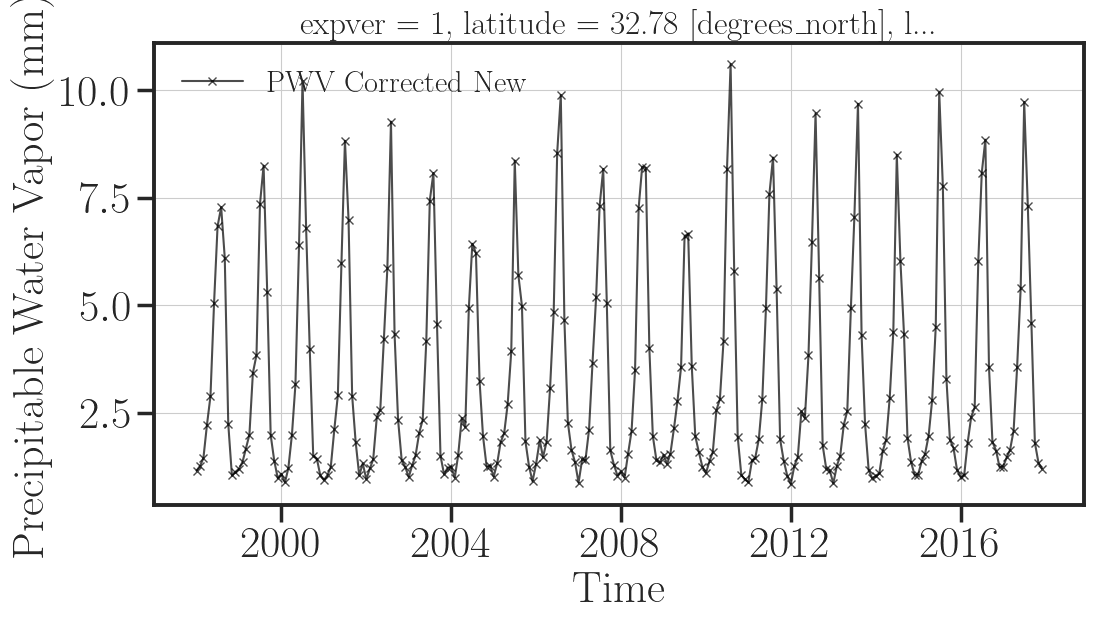

In [183]:

# Example usage
lat_hanle = 32.7789
lon_hanle = 78.965
#ds_point = era5.sel(latitude=lat_hanle, longitude=lon_hanle, method='nearest')
ds_point = era5.interp(latitude=lat_hanle, longitude=lon_hanle,method='linear')
ds_point = ds_point.sel(time=slice("1998-01-01", "2017-12-31"))

pressure_threshold = surface_pressure_data['sp'].sel(latitude=lat_hanle, longitude=lon_hanle, method='nearest')
pressure_threshold = pressure_threshold.sel(time=slice("1998-01-01", "2017-12-31"))

pwv_corr_new = calculate_pwv_pressure(ds_point.q, ds_point.level, pressure_thresholds=pressure_threshold)

# Plotting results
plt.figure(figsize=(12, 6))
pwv_corr_new.plot(color='black', label='PWV Corrected New', linestyle='-', alpha=0.7, marker='x')
#pwv_corr_old.plot(color='blue', label='PWV Corrected', linestyle='--', alpha=0.9, marker='o')
plt.xlabel('Time')
plt.ylabel('Precipitable Water Vapor (mm)')
plt.grid(True)
plt.legend()
plt.show()

In [13]:
import math

def calculate_pressure(P_b, T_b, L_b, h, h_b, R_star=8.3144598, g_0=9.80665, M=0.028964425278793993):
    T_h = T_b - L_b * (h - h_b)
    exponent = (g_0 * M) / (R_star * L_b)
    pressure = P_b * (T_h / T_b) ** exponent
    return pressure

# Example usage:
P_b = 101325  # reference pressure at sea level in Pa
T_b = 288.15  # reference temperature at sea level in K
L_b = 0.0065  # temperature lapse rate in K/m
h = 4500     # height at which pressure is calculated in m
h_b = 00       # height of reference level in m

pressure = calculate_pressure(P_b, T_b, L_b, h, h_b)
print(f"Pressure at {h} meters: {pressure:.2f} Pa")


Pressure at 4500 meters: 57728.84 Pa


In [185]:
elevation_data = xr.open_dataset('fractional_land.0.25-deg.nc')

/Users/wavefunction/Dropbox (ASU)/THz_Mac/Thz/lib/python3.11/site-packages/xarray/coding/times.py:170: SerializationWarning: Ambiguous reference date string: 1-1-1 0:0:0. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 0:0:0). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/Users/wavefunction/Dropbox (ASU)/THz_Mac/Thz/lib/python3.11/site-packages/xarray/coding/times.py:995: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/wavefunction/Dropbox (ASU)/THz_Mac/Thz/lib/python3.11/site-packages/xarray/core/indexing.py:630: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects,

In [186]:
elevation_data

<xarray.Dataset> Size: 4MB
Dimensions:  (lat: 720, lon: 1440, time: 1)
Coordinates:
  * lat      (lat) float32 3kB 89.88 89.62 89.38 89.12 ... -89.38 -89.62 -89.88
  * lon      (lon) float32 6kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * time     (time) object 8B 0001-01-01 00:00:00
Data variables:
    data     (time, lat, lon) float32 4MB ...
Attributes:
    history:  \nFractional land (0-1) calculated from the TBASE 5-minute\nlat...

#### Analysis for Mauna Kea

In [187]:
Mauna_Kea = {'lat': 19.8230, 'lon': 204.5306,
                'elevation': 4200, 'name': 'Mauna Kea'}
# Mauna_Kea = {'lat': -23.029, 'lon':292.245,
#                     'elevation': 5107, 'name': 'Mauna Kea'}

             
mauna_kea_pressure_data = xr.open_dataset('mauna_kea.nc')
# mauna_kea_pressure_data = xr.open_dataset('ALMA.nc')
print(mauna_kea_pressure_data)

#print(mauna_kea_pressure_data)

mauna_kea_pressure_data = mauna_kea_pressure_data.interp(latitude=Mauna_Kea['lat'], longitude=Mauna_Kea['lon']-360,method='linear')

<xarray.Dataset> Size: 7MB
Dimensions:    (longitude: 5, latitude: 5, level: 37, time: 312)
Coordinates:
  * longitude  (longitude) float32 20B -156.0 -155.8 -155.5 -155.2 -155.0
  * latitude   (latitude) float32 20B 20.5 20.25 20.0 19.75 19.5
  * level      (level) int32 148B 1 2 3 5 7 10 20 ... 875 900 925 950 975 1000
  * time       (time) datetime64[ns] 2kB 1998-01-01 1998-02-01 ... 2023-12-01
Data variables:
    o3         (time, level, latitude, longitude) float64 2MB ...
    q          (time, level, latitude, longitude) float64 2MB ...
    t          (time, level, latitude, longitude) float64 2MB ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-07-03 04:44:12 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...


In [188]:
mauna_kea_surface_pressure = xr.open_dataset('mauna_kea_pressure.nc')

In [189]:
mauna_kea_surface_pressure

<xarray.Dataset> Size: 340kB
Dimensions:    (longitude: 9, latitude: 5, time: 312)
Coordinates:
  * longitude  (longitude) float32 36B -156.0 -155.8 -155.5 ... -154.2 -154.0
  * latitude   (latitude) float32 20B 20.5 20.25 20.0 19.75 19.5
  * time       (time) datetime64[ns] 2kB 1998-01-01 1998-02-01 ... 2023-12-01
Data variables:
    t2m        (time, latitude, longitude) float64 112kB ...
    sst        (time, latitude, longitude) float64 112kB ...
    sp         (time, latitude, longitude) float64 112kB ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-07-03 22:39:02 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

/var/folders/ng/2lqpk97j4xz4qpsvv8tt4tv80000gn/T/ipykernel_57182/1458506206.py:69: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "median": df["PWV_mm"].resample("M").median(),
/var/folders/ng/2lqpk97j4xz4qpsvv8tt4tv80000gn/T/ipykernel_57182/1458506206.py:70: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "q25"   : df["PWV_mm"].resample("M").quantile(0.25),
/var/folders/ng/2lqpk97j4xz4qpsvv8tt4tv80000gn/T/ipykernel_57182/1458506206.py:71: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "q75"   : df["PWV_mm"].resample("M").quantile(0.75),


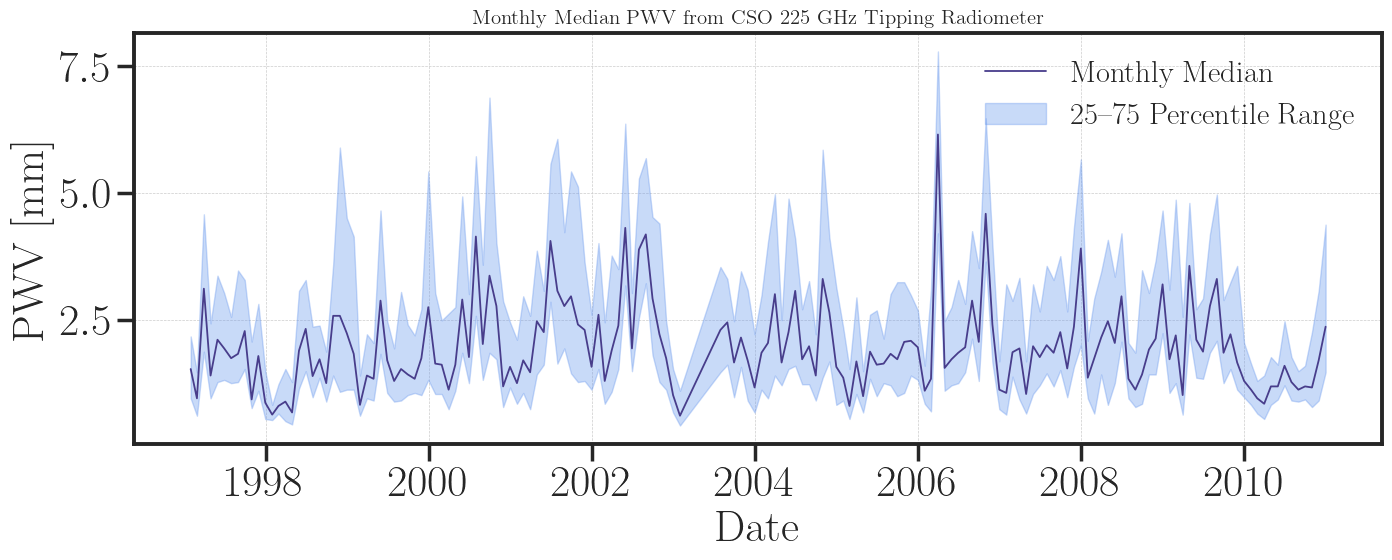

In [190]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# 1.  Where are the tauXXXX folders?
# ------------------------------------------------------------------
DATA_ROOT = "Mauna_Kea_Tipper_CSO"  # ⬅️  change this!

# ------------------------------------------------------------------
# 2.  Helper to convert (decimal hour) → datetime
# ------------------------------------------------------------------
def decimal_hour_to_time(dh):
    h = int(dh)
    m = int((dh - h) * 60)
    s = int(round(((dh - h) * 60 - m) * 60))
    return f"{h:02d}:{m:02d}:{s:02d}"

# ------------------------------------------------------------------
# 3.  Walk folders & files
# ------------------------------------------------------------------
records = []

year_folders = sorted(glob.glob(os.path.join(DATA_ROOT, "tau*")))
for yfolder in year_folders:
    dat_files = sorted(glob.glob(os.path.join(yfolder, "*.dat")))
    for fp in dat_files:
        # extract date from filename (YYYYMMDD.dat)
        fname = os.path.basename(fp)
        y, m, d = fname[:4], fname[4:6], fname[6:8]

        # read τ225, error
        with open(fp, "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) != 3:
                    continue
                dh, tau, err = map(float, parts)

                # simple quality-control: skip blatantly bad measurements
                if tau <= 0 or err > 0.05:
                    continue

                if 0.0 <= dh < 24.0:                     # skip clearly bad decimal hours
                    base_date = pd.Timestamp(year=int(y), month=int(m), day=int(d))
                    ts = base_date + pd.to_timedelta(dh, unit="h")
                else:
                    continue  

                # convert τ225 to PWV formula \text{PWV [mm]} \;=\; 21.422 \,\tau_{225} \;-\; 0.296 .
                # Note: the original formula is PWV = (tau - 0.017) / 0.04, but this is equivalent
                pwv = 21.422 * tau - 0.296  # ← conversion
                # pwv = (tau - 0.017) / 0.04        # ← conversion
                records.append((ts, pwv))

# ------------------------------------------------------------------
# 4.  DataFrame of all samples
# ------------------------------------------------------------------
df = pd.DataFrame(records, columns=["DateTime", "PWV_mm"])
df.set_index("DateTime", inplace=True)
df.sort_index(inplace=True)

# ------------------------------------------------------------------
# 5.  Monthly statistics
# ------------------------------------------------------------------
monthly = pd.DataFrame({
    "median": df["PWV_mm"].resample("M").median(),
    "q25"   : df["PWV_mm"].resample("M").quantile(0.25),
    "q75"   : df["PWV_mm"].resample("M").quantile(0.75),
})

# optional: drop months with too few points
monthly = monthly.dropna(how="any")

# ------------------------------------------------------------------
# 6.  Plot
# ------------------------------------------------------------------
plt.figure(figsize=(14, 6))
plt.plot(monthly.index, monthly["median"], color="darkslateblue",
         linewidth=1.3, label="Monthly Median")
plt.fill_between(monthly.index, monthly["q25"], monthly["q75"],
                 color="cornflowerblue", alpha=0.35,
                 label="25–75 Percentile Range")

plt.title("Monthly Median PWV from CSO 225 GHz Tipping Radiometer",
          fontsize=15)
plt.xlabel("Date")
plt.ylabel("PWV  [mm]")
plt.grid(True, ls="--", lw=0.5)
plt.legend()
plt.tight_layout()
plt.savefig("cso_pwv_monthly.png", dpi=300)
plt.show()

In [191]:

mauna_kea_surface_pressure = xr.open_dataset('mauna_kea_pressure.nc')
# mauna_kea_surface_pressure = xr.open_dataset('ALMA_pressure.nc')
## change the name of 'valid_time' to 'time'
#mauna_kea_surface_pressure = mauna_kea_surface_pressure.rename({'valid_time': 'time'})

# select the concerned data for lat and lon
temperature_data = mauna_kea_surface_pressure['t2m'].interp(latitude=Mauna_Kea['lat'], longitude=Mauna_Kea['lon']-360,method='linear')
print(temperature_data)

# Apply the conversion function to your temperature data
pressure_values = calculate_pressure(P_b, temperature_data, L_b, h, h_b)

# Create a new DataArray for the surface pressure data
surface_pressure_data_elevation = xr.DataArray(pressure_values, coords=temperature_data.coords, dims=temperature_data.dims, name='sp')

# Verify the new DataArray
print(surface_pressure_data_elevation)


print(mauna_kea_surface_pressure)
mauna_kea_surface_pressure = mauna_kea_surface_pressure['sp'].interp(latitude=Mauna_Kea['lat'], longitude=Mauna_Kea['lon']-360,method='linear')

print(mauna_kea_surface_pressure)

<xarray.DataArray 't2m' (time: 312)> Size: 2kB
array([286.66392192, 286.53617905, 286.61265869, 285.87948083,
       286.46703821, 288.24692608, 288.79473936, 288.96875055,
       288.31181167, 288.11197781, 287.14112648, 285.70607777,
       285.52341746, 284.85729734, 285.17938706, 285.73628867,
       288.0294305 , 288.62655536, 288.75942056, 289.09714915,
       288.50693757, 288.32305343, 286.81402191, 286.31566606,
       284.4670768 , 286.3728523 , 286.36923281, 286.37726367,
       288.39934809, 288.94420553, 289.32284637, 289.66561549,
       289.46730175, 288.7211955 , 287.08647993, 286.28356816,
       286.3608506 , 285.63891183, 285.72896165, 286.48438628,
       287.59571166, 288.36292529, 289.32448774, 289.83496608,
       289.20264134, 288.43215455, 288.54356804, 286.48622386,
       286.20456107, 285.02887594, 285.79737987, 287.6961251 ,
       288.21288621, 288.90572233, 289.81902989, 289.96684301,
       289.11722524, 288.76454882, 288.11188058, 286.44040502,
       2

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming you have all the required functions and data already loaded
# pressure_threshold_old = calculate_pressure(P_b, T_b, L_b, Mauna_Kea['elevation'], h_b)
# print(f"Pressure at {Mauna_Kea['elevation']} meters: {pressure_threshold_old:.2f} Pa")
pressure_threshold_old = surface_pressure_data_elevation.sel(time=slice("1998-01-01", "2023-12-31"))

pressure_threshold_new = mauna_kea_surface_pressure.sel(time=slice("1998-01-01", "2023-12-31"))


# keep the full dataset
# mk_ds = (
#     xr.open_dataset("ALMA_pressure.nc")
#       .rename({"valid_time": "time"})
# )
mk_ds = (xr.open_dataset("mauna_kea_pressure.nc"))


# work with sp later
pressure_threshold_new = (
    mk_ds["sp"]                               # take the variable
      .interp(latitude=Mauna_Kea["lat"],
              longitude=Mauna_Kea["lon"] - 360,
              method="linear")
      .sel(time=slice("1998-01-01", "2023-12-31"))
)

# make pressure_threshold_new a 1-D DataArray (time) at the Mauna Kea summit
# pressure_threshold_new = (
#     mauna_kea_surface_pressure["sp"]                       # take the variable
#       .sel(latitude=Mauna_Kea["lat"],                      # nearest grid node
#            longitude=Mauna_Kea["lon"],
#            method="nearest")                               # or use .interp(...)
#       .sel(time=slice("2010-01-01", "2023-12-31"))         # match time span
#       .assign_coords(latitude=Mauna_Kea["lat"],            # scalar coords
#                      longitude=Mauna_Kea["lon"])
# )

# Mauna Kea coordinates
lat_mk  =  19.823
lon_mk  = -155.4694                     # −180 … +180 convention
lon360  = lon_mk % 360                  # → 204.5306 °

data = (
    era5
      .interp(latitude=lat_mk, longitude=lon360, method="linear")
      .sel(time=slice("1998", "2023"))          # keep 2010-2023
      .assign_coords(longitude=lon_mk)          # put the “nice” −155.5° back
)

q = data['q']
level = data['level']

#pwv_data_old = calculate_pwv(q, level, pressure_threshold_old)
pwv_data_old = calculate_pwv_pressure(q, level, pressure_threshold_old)
pwv_data_new = calculate_pwv_pressure(q, level, pressure_threshold_new)

# Extract values and time for plotting
pwv_old_values = pwv_data_old.values
pwv_new_values = pwv_data_new.values
time_values = pd.to_datetime(pwv_data_old.time.values).year + (pd.to_datetime(pwv_data_old.time.values).month - 1) / 12




/var/folders/ng/2lqpk97j4xz4qpsvv8tt4tv80000gn/T/ipykernel_57182/3528457406.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.06, 0, 1, 1])  # Adjust the rect parameter to make room for the common y-label


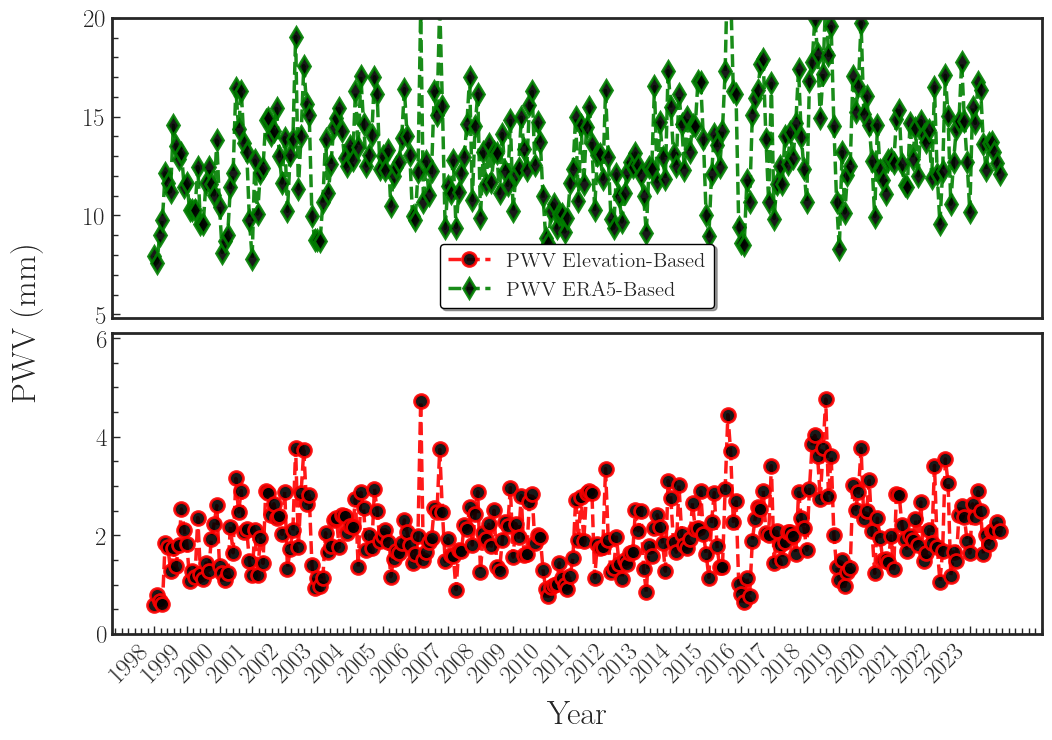

In [193]:
# Setup plot with desired aesthetics
plt.rc('font', family='serif', size=16)
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['ytick.minor.size'] = 4

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 8), gridspec_kw={'hspace': 0.05})

# Plotting combined PWV data
line1, = ax2.plot(time_values, pwv_old_values, label='PWV Elevation-Based', marker='o', linestyle='--', color='red', 
                  markerfacecolor='black', markeredgewidth=2, markersize=10, linewidth=2.5, alpha=0.9)
line2, = ax1.plot(time_values, pwv_new_values, label='PWV ERA5-Based', marker='d', linestyle='--', color='green', 
                  markerfacecolor='black', markeredgewidth=2, markersize=10, linewidth=2.5, alpha=0.9)
ax1.set_ylim(4.8, 20)

# Calculate residuals
residuals = pwv_new_values - pwv_old_values

# Plotting residuals
# line3, = ax2.plot(time_values, residuals, label='PWV Residuals', linestyle='--', color='blue',
#                   markerfacecolor='black', markeredgewidth=2, markersize=8, linewidth=2, alpha=0.8, marker='X')
ax2.set_ylim(0, 6.1)

# Common y-axis label
fig.text(0.04, 0.5, 'PWV (mm)', va='center', rotation='vertical', fontsize=24)

# Setting up x-ticks
# Setting up x-ticks at the beginning of each year
x_ticks = np.arange(1998, 2024, 1)
ax2.set_xticks(x_ticks)
ax2.set_xticklabels([f'{int(year)}' for year in x_ticks], rotation=45, ha='right', va='top', fontsize=14)


# Apply formatting to axes and plot borders for both subplots
for ax in [ax1, ax2]:
    ax.set_facecolor('white')
    ax.spines['top'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.tick_params(axis='both', direction='in', width=1, labelsize=18, which='both')
    ax.minorticks_on()

# Remove ticks and minorticks on the shared line between the plots
ax1.tick_params(labelbottom=False, bottom=False, which='both')
ax2.tick_params(top=False, which='both')

# Combine legends from both subplots
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, ncol=1, loc='best', fontsize=15,
           frameon=True, facecolor='white', edgecolor='black', framealpha=1, shadow=True)

ax2.set_xlabel('Year', labelpad=10, fontsize=24)

plt.tight_layout(rect=[0.06, 0, 1, 1])  # Adjust the rect parameter to make room for the common y-label
#plt.savefig('PWV_Muana_Kea_Comparison.pdf', dpi=600)
plt.show()

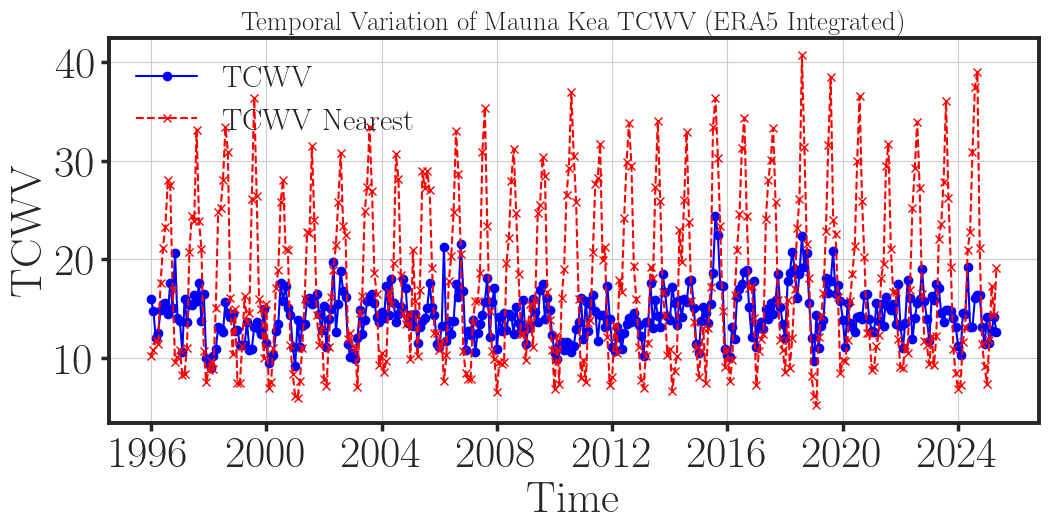

In [194]:
# Extract the integrated TCWV parameter from the ERA5 integrated dataset,
# then interpolate at Mauna Kea's location using the already defined Mauna_Kea dictionary.
# (Note: We assume the integrated TCWV variable is named 'tcwv' in the dataset.)
tcwv = era5_integrated['tcwv']
mauna_kea_tcwv = tcwv.interp(latitude=Mauna_Kea['lat'], longitude=Mauna_Kea['lon'], method='linear')
mauna_kea_tcwv_sel = tcwv.sel(latitude=Mauna_Kea['lat'], longitude=Mauna_Kea['lon']-360, method='nearest')

# Plot the temporal variation of Mauna Kea TCWV
plt.figure(figsize=(12, 5))
mauna_kea_tcwv.plot(color='blue', marker='o', linestyle='-', label='TCWV')
mauna_kea_tcwv_sel.plot(color='red', marker='x', linestyle='--', label='TCWV Nearest')
plt.title("Temporal Variation of Mauna Kea TCWV (ERA5 Integrated)")
plt.xlabel("Time")
plt.ylabel("TCWV")
plt.grid(True)
plt.legend()
plt.show()

In [195]:
# =======================================================================
#  FINAL COMBINED PWV PLOT (FOR USE WITH REAL DATA)
#  - Merges CSO, Elevation-Based, and ERA5 PWV data
#  - Unifies disparate x-axis formats into datetime objects
#  - Renders all data on a single, professionally styled plot
# =======================================================================
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import calendar
from datetime import datetime, timedelta

# =======================================================================
#  PART 1: PREREQUISITES & SETUP (USER ACTION REQUIRED)
# =======================================================================
# This script assumes the following data is available in your environment.
# Please ensure these are loaded correctly before proceeding.

# --- 1a. Path to the CSO Tipper Data ---
# Ensure this path points to your directory containing the 'tauXXXX' folders.
DATA_ROOT = "Mauna_Kea_Tipper_CSO"

# --- 1b. Load Elevation-Based and ERA5 PWV Datasets ---
# The variables `time_values`, `pwv_old_values`, and `pwv_new_values`
# must be loaded into memory. Uncomment and adapt one of the following
# methods, or use your own data loading method.

# Example if your data is in a CSV file:
# df_pwv = pd.read_csv("path/to/your/pwv_data.csv")
# time_values = df_pwv['time_column_name'].values
# pwv_old_values = df_pwv['pwv_old_column_name'].values
# pwv_new_values = df_pwv['pwv_new_column_name'].values

# Example if your data is in NumPy arrays:
# time_values = np.load('path/to/your/time_values.npy')
# pwv_old_values = np.load('path/to/your/pwv_old_values.npy')
# pwv_new_values = np.load('path/to/your/pwv_new_values.npy')

# --- Check if the data exists before proceeding ---
if 'time_values' not in locals() or 'pwv_old_values' not in locals():
    raise NameError("The variables 'time_values', 'pwv_old_values', and 'pwv_new_values' are not loaded. "
                    "Please load your data in Part 1 of the script before proceeding.")


# =======================================================================
#  PART 2: DATA PROCESSING AND X-AXIS UNIFICATION
# =======================================================================
print("--- Part 2: Processing data and unifying x-axis formats ---")

# --- 2a. Process the CSO data from raw files ---
print(f"Reading CSO data from: {os.path.abspath(DATA_ROOT)}")
if not os.path.isdir(DATA_ROOT):
    raise FileNotFoundError(f"The specified directory was not found: '{DATA_ROOT}'. Please check the path.")

records = []
year_folders = sorted(glob.glob(os.path.join(DATA_ROOT, "tau*")))
for yfolder in year_folders:
    dat_files = sorted(glob.glob(os.path.join(yfolder, "*.dat")))
    for fp in dat_files:
        fname = os.path.basename(fp)
        y, m, d = fname[:4], fname[4:6], fname[6:8]
        with open(fp, "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) != 3: continue
                dh, tau, err = map(float, parts)
                if tau <= 0 or err > 0.05 or not (0.0 <= dh < 24.0): continue
                ts = pd.Timestamp(year=int(y), month=int(m), day=int(d)) + pd.to_timedelta(dh, unit="h")
                pwv = 21.422 * tau - 0.296
                records.append((ts, pwv))

df_cso = pd.DataFrame(records, columns=["DateTime", "PWV_mm"]).set_index("DateTime").sort_index()
monthly = pd.DataFrame({
    "median": df_cso["PWV_mm"].resample("M").median(),
    "q25": df_cso["PWV_mm"].resample("M").quantile(0.25),
    "q75": df_cso["PWV_mm"].resample("M").quantile(0.75),
}).dropna()
print(f"CSO data processed. Found {len(df_cso)} valid records.")

# --- 2b. DEBUG & FIX X-AXIS: Convert float years to datetime objects if necessary ---
# This function handles the case where `time_values` might be float years (e.g., 1998.5)
def convert_float_years_to_datetime(float_years):
    datetimes = []
    for y_float in float_years:
        year = int(y_float)
        remainder = y_float - year
        days_in_year = 366 if calendar.isleap(year) else 365
        start_of_year = datetime(year, 1, 1)
        day_offset = timedelta(days=remainder * days_in_year)
        datetimes.append(start_of_year + day_offset)
    return pd.to_datetime(datetimes)

# Check the data type of the x-axis and convert ONLY if it's not already a datetime type
if not np.issubdtype(np.asarray(time_values).dtype, np.datetime64):
    print("Detected a non-datetime x-axis for ERA5/Elevation data. Converting...")
    time_values_datetime = convert_float_years_to_datetime(time_values)
    print("Conversion complete.")
else:
    print("ERA5/Elevation x-axis is already in datetime format. No conversion needed.")
    time_values_datetime = pd.to_datetime(time_values)


# =======================================================================
#  PART 3: THE UNIFIED PLOT
# =======================================================================
print("\n--- Part 3: Generating the final combined plot ---")



--- Part 2: Processing data and unifying x-axis formats ---
Reading CSO data from: /Users/wavefunction/ASU Dropbox/Tanmay Singh/THz_Mac/Mauna_Kea_Tipper_CSO
CSO data processed. Found 609086 valid records.
Detected a non-datetime x-axis for ERA5/Elevation data. Converting...
Conversion complete.

--- Part 3: Generating the final combined plot ---


/var/folders/ng/2lqpk97j4xz4qpsvv8tt4tv80000gn/T/ipykernel_57182/1502082015.py:77: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "median": df_cso["PWV_mm"].resample("M").median(),
/var/folders/ng/2lqpk97j4xz4qpsvv8tt4tv80000gn/T/ipykernel_57182/1502082015.py:78: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "q25": df_cso["PWV_mm"].resample("M").quantile(0.25),
/var/folders/ng/2lqpk97j4xz4qpsvv8tt4tv80000gn/T/ipykernel_57182/1502082015.py:79: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "q75": df_cso["PWV_mm"].resample("M").quantile(0.75),


DatetimeIndex(['1997-01-31', '1997-02-28', '1997-03-31', '1997-04-30',
               '1997-05-31', '1997-06-30', '1997-07-31', '1997-08-31',
               '1997-09-30', '1997-10-31',
               ...
               '2010-03-31', '2010-04-30', '2010-05-31', '2010-06-30',
               '2010-07-31', '2010-08-31', '2010-09-30', '2010-10-31',
               '2010-11-30', '2010-12-31'],
              dtype='datetime64[ns]', name='DateTime', length=163, freq=None)
DatetimeIndex([       '1998-01-01 00:00:00', '1998-01-31 09:59:59.999998',
               '1998-03-02 20:00:00.000002',        '1998-04-02 06:00:00',
               '1998-05-02 15:59:59.999998', '1998-06-02 02:00:00.000002',
                      '1998-07-02 12:00:00', '1998-08-01 21:59:59.999998',
               '1998-09-01 08:00:00.000002',        '1998-10-01 18:00:00',
               ...
               '2023-03-02 20:00:00.000002',        '2023-04-02 06:00:00',
               '2023-05-02 15:59:59.999998', '2023-06-02 02:00:

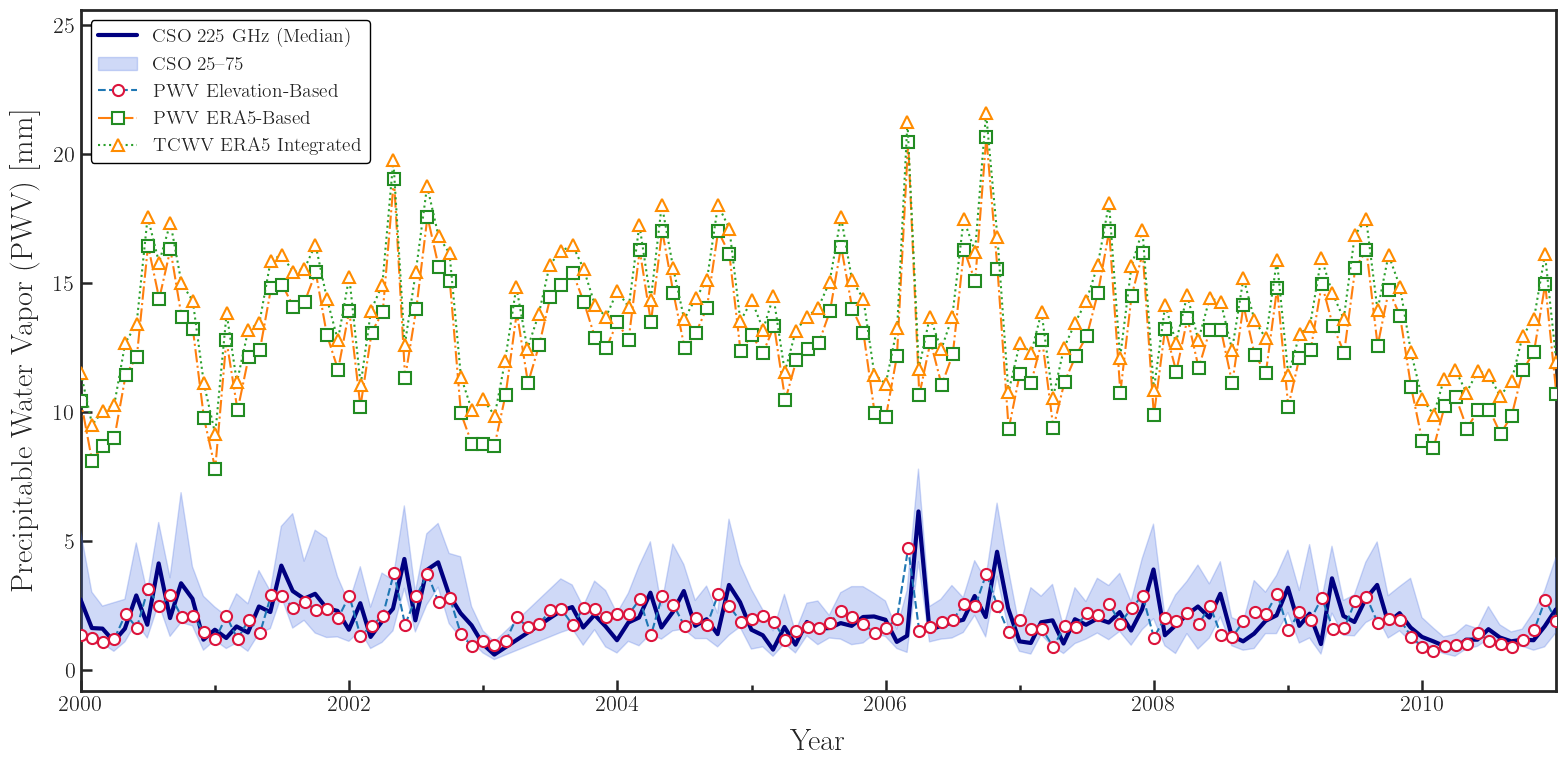

In [196]:
# --- 3a. Setup plot with a clean, professional style ---
plt.rcParams.update({
    "font.family": "serif", "font.size": 18,
    "xtick.major.size": 8, "xtick.minor.size": 4,
    "ytick.major.size": 8, "ytick.minor.size": 4,
    "axes.linewidth": 2.0,
})
fig, ax = plt.subplots(figsize=(16, 8))

# --- 3b. Plot all three datasets on the single axis ---
ax.plot(monthly.index, monthly['median'],
        color='navy', lw=3.0, label='CSO 225 GHz (Median)', zorder=10)
print(monthly.index)

ax.fill_between(monthly.index, monthly['q25'], monthly['q75'],
                color='royalblue', alpha=0.25, label='CSO 25–75% IQR', zorder=9)
ax.plot(time_values_datetime, pwv_old_values,
        label='PWV Elevation-Based', marker='o', linestyle='--',
        mfc='white', mec='crimson', mew=1.5, ms=8, zorder=11)
print(time_values_datetime)
ax.plot(time_values_datetime, pwv_new_values,
        label='PWV ERA5-Based', marker='s', linestyle='-.',
        mfc='white', mec='forestgreen', mew=1.5, ms=8, zorder=12)
print(time_values_datetime)
# add the mauna_kea_tcwv data
ax.plot(mauna_kea_tcwv.valid_time, mauna_kea_tcwv,
        label='TCWV ERA5 Integrated', marker='^', linestyle=':',
        mfc='white', mec='darkorange', mew=1.5, ms=8, zorder=13)
print(mauna_kea_tcwv.valid_time,'\n')




# --- 3c. Final Cosmetics and Formatting ---
ax.set_ylabel("Precipitable Water Vapor (PWV) [mm]", fontsize=22, labelpad=10)
ax.set_xlabel("Year", fontsize=22, labelpad=10)
#ax.set_title("Combined Maunakea PWV Comparison", fontsize=24, pad=15)
# ax.set_ylim(0, 22)

# Determine axis limits from all available data
min_date = min(monthly.index.min(), time_values_datetime.min())
max_date = max(monthly.index.max(), time_values_datetime.max())
ax.set_xlim(min_date, max_date)

ax.xaxis.set_major_locator(mdates.YearLocator(base=2))
ax.xaxis.set_minor_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.tick_params(axis='both', which='both', direction='in', width=1.8, labelsize=16)

# set x limit from 2000 ro 2010
ax.set_xlim(pd.Timestamp("2000-01-01"), pd.Timestamp("2010-12-31"))


ax.legend(fontsize=14, frameon=True, facecolor='white',
          edgecolor='black', framealpha=1, loc='upper left')
ax.grid(False)
plt.tight_layout()
plt.savefig("PWV_Maunakea_Combined_Plot_Final.png", dpi=400)
plt.show()

### ALMA comparison

In [62]:
# Mauna_Kea = {'lat': 19.8230, 'lon': 204.5306,
#                 'elevation': 4200, 'name': 'Mauna Kea'}
ALMA = {'lat': -23.029, 'lon':292.245,
                    'elevation': 5107, 'name': 'ALMA'}

             
# mauna_kea_pressure_data = xr.open_dataset('mauna_kea.nc')
ALMA_pressure_data = xr.open_dataset('ALMA.nc')
# print(mauna_kea_pressure_data)

print(ALMA_pressure_data)

ALMA_pressure_data = ALMA_pressure_data.interp(latitude=ALMA['lat'], longitude=ALMA['lon']-360,method='linear')


<xarray.Dataset> Size: 11MB
Dimensions:         (valid_time: 304, pressure_level: 37, latitude: 9,
                     longitude: 13)
Coordinates:
    number          int64 8B ...
  * valid_time      (valid_time) datetime64[ns] 2kB 2000-01-01 ... 2025-04-01
  * pressure_level  (pressure_level) float64 296B 1e+03 975.0 950.0 ... 2.0 1.0
  * latitude        (latitude) float64 72B -22.0 -22.25 -22.5 ... -23.75 -24.0
  * longitude       (longitude) float64 104B -69.0 -68.75 -68.5 ... -66.25 -66.0
    expver          (valid_time) <U4 5kB ...
Data variables:
    t               (valid_time, pressure_level, latitude, longitude) float32 5MB ...
    q               (valid_time, pressure_level, latitude, longitude) float32 5MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forec

In [63]:
ALMA_surface_pressure = xr.open_dataset('ALMA_pressure.nc')
ALMA_surface_pressure

<xarray.Dataset> Size: 469kB
Dimensions:     (valid_time: 328, latitude: 9, longitude: 13)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 3kB 1998-01-01 ... 2025-04-01
  * latitude    (latitude) float64 72B -22.0 -22.25 -22.5 ... -23.5 -23.75 -24.0
  * longitude   (longitude) float64 104B -69.0 -68.75 -68.5 ... -66.25 -66.0
    expver      (valid_time) <U4 5kB ...
Data variables:
    sst         (valid_time, latitude, longitude) float32 154kB ...
    sp          (valid_time, latitude, longitude) float32 154kB ...
    t2m         (valid_time, latitude, longitude) float32 154kB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

In [64]:

ALMA_surface_pressure = xr.open_dataset('ALMA_pressure.nc')
# mauna_kea_surface_pressure = xr.open_dataset('ALMA_pressure.nc')
## change the name of 'valid_time' to 'time'
#mauna_kea_surface_pressure = mauna_kea_surface_pressure.rename({'valid_time': 'time'})

# select the concerned data for lat and lon
temperature_data = ALMA_surface_pressure['t2m'].interp(latitude=ALMA['lat'], longitude=ALMA['lon']-360,method='linear')
print(temperature_data)

# Apply the conversion function to your temperature data
pressure_values = calculate_pressure(P_b, temperature_data, L_b, h, h_b)

# Create a new DataArray for the surface pressure data
surface_pressure_data_elevation = xr.DataArray(pressure_values, coords=temperature_data.coords, dims=temperature_data.dims, name='sp')

# Verify the new DataArray
print(surface_pressure_data_elevation)


print(ALMA_surface_pressure)
ALMA_surface_pressure = ALMA_surface_pressure['sp'].interp(latitude=ALMA['lat'], longitude=ALMA['lon']-360,method='linear')

print(ALMA_surface_pressure)

<xarray.DataArray 't2m' (valid_time: 328)> Size: 3kB
array([282.27283328, 280.26379203, 280.23905812, 275.94002484,
       273.7216818 , 272.16004055, 269.94853445, 270.08507359,
       273.38717547, 276.58340047, 278.27053914, 279.07218656,
       278.66495703, 278.77680406, 277.34568289, 276.10485469,
       273.80154227, 270.11043016, 269.1200107 , 273.04178234,
       274.8016268 , 277.36221016, 277.10926734, 279.28960375,
       278.7095    , 277.77217023, 277.45372242, 276.89974625,
       272.27166164, 268.64310898, 267.51725336, 270.30475344,
       273.87921914, 277.59396242, 277.45537672, 279.60839492,
       278.20886914, 278.59875133, 277.02422461, 275.93828094,
       270.60264617, 272.09425344, 271.41596016, 273.59016523,
       274.2632057 , 277.60774234, 279.16952203, 277.95316891,
       279.3567825 , 278.17133297, 278.03096711, 276.090685  ,
       271.5765007 , 270.04800078, 265.47056477, 271.2148582 ,
       274.96335234, 277.47101187, 278.99415312, 279.76030992,
  

In [65]:
tcwv = era5_integrated['tcwv']
print(tcwv)

<xarray.DataArray 'tcwv' (valid_time: 353, latitude: 721, longitude: 1440)> Size: 1GB
[366498720 values with dtype=float32]
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 3kB 1996-01-01 ... 2025-05-01
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    expver      (valid_time) <U4 6kB ...
Attributes: (12/32)
    GRIB_paramId:                             137
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      1038240
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            avgua
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               kg m**-2
    long_name:                                Total column vertically-integra...

In [66]:

# Interpolate the ERA5 integrated TCWV data for the ALMA site (convert ALMA longitude to -180–180)
tcwv_alma = tcwv.interp(latitude=ALMA['lat'], longitude=ALMA['lon'], method='linear')


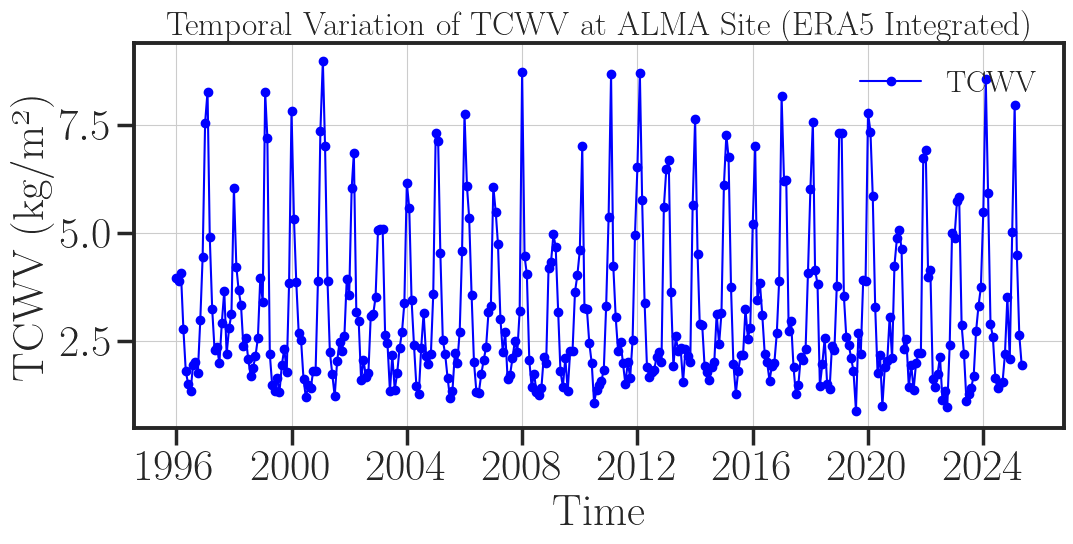

In [67]:
plt.figure(figsize=(12, 5))
tcwv_alma.plot(color='blue', marker='o', linestyle='-', label='TCWV')
plt.title("Temporal Variation of TCWV at ALMA Site (ERA5 Integrated)")
plt.xlabel("Time")
plt.ylabel("TCWV (kg/m²)")
plt.grid(True)
plt.legend()
plt.show()

In [68]:
ALMA_site['elevation'] 

5107

In [69]:
pressure_threshold_alma_old = calculate_pressure(P_b, t2m_alma, L_b, ALMA_site['elevation'], h_b).sel(time=time_slice)
pressure_threshold_alma_old.mean().values.item()




51620.515141941825

In [70]:

pressure_threshold_alma_new = surface_data_alma["sp"].sel(time=time_slice)
pressure_threshold_alma_new.mean().values.item()

60303.326623805624

In [77]:
# =======================================================================
#  PRECIPITABLE WATER VAPOR (PWV) ANALYSIS FOR THE ALMA OBSERVATORY
# =======================================================================
# VERSION 6: This version has been significantly refined to produce a
#            professional, publication-quality plot with enhanced
#            aesthetics, improved data representation, and specific
#            time limits as requested.
# =======================================================================

import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import AutoMinorLocator
from pathlib import Path
from astropy.time import Time
import seaborn as sns

# =======================================================================
#  PART 1: SETUP AND CONFIGURATION
# =======================================================================

# --- Site Parameters for ALMA ---
ALMA_site = {
    'lat': -23.029,
    'lon': -67.755,
    'elevation': 5107 ,
    'name': 'ALMA'
}



def calculate_pwv_pressure_alma(q, pressure_level_da, pressure_thresholds):
    """Robust function for ALMA PWV calculation."""
    print("...using robust 'calculate_pwv_pressure_alma' function...")
    g = 9.81
    aligned_thresholds = pressure_thresholds.interp(time=q.time, method="nearest")
    pwv_list = []

    for time_step in q.time.values:
        q_profile = q.sel(time=time_step)
        pressure_threshold = aligned_thresholds.sel(time=time_step).values.item()
        p_levels_pa = q_profile.coords['pressure_level'].values * 100
        mask = p_levels_pa <= pressure_threshold
        if np.sum(mask) < 2:
            pwv_list.append(np.nan)
            continue
        p_integ = p_levels_pa[mask]
        q_integ = q_profile.values[mask]
        q_at_surface = q_profile.interp(pressure_level=pressure_threshold / 100).item()
        p_combined = np.append(p_integ, pressure_threshold)
        q_combined = np.append(q_integ, q_at_surface)
        sort_indices = np.argsort(p_combined)
        p_sorted, q_sorted = p_combined[sort_indices], q_combined[sort_indices]
        finite_mask = np.isfinite(q_sorted)
        if np.sum(finite_mask) < 2:
            pwv_list.append(np.nan)
            continue
        integral = np.trapz(q_sorted[finite_mask], p_sorted[finite_mask])
        pwv_list.append((1.0 / g) * integral)
    return xr.DataArray(pwv_list, coords={'time': q.time}, dims=['time'])
import numpy as np
import xarray as xr
from scipy.interpolate import PchipInterpolator

def calculate_pwv_with_pchip_alma(q, pressure_level_da, pressure_thresholds):
    """
    This function replicates the user's original PCHIP-based algorithm,
    but is adapted to work with the ALMA dataset by:
      1. Removing the selection for the 'expver' dimension.
      2. Using 'pressure_level' as the vertical coordinate name.
      3. Using robust time selection to prevent errors.
    """
    print("...using PCHIP-based algorithm adapted for ALMA data...")
    rho_w = 1 
    g = 9.81
    # This variable is now sourced directly from the DataArray's coordinates
    # levels = pressure_level_da.values * 100

    pwv_list = []

    for time_step in q.time:
        # Use robust time selection to prevent KeyErrors
        pc = pressure_thresholds.sel(time=time_step, method='nearest').values.item()
        
        q_at_time = q.sel(time=time_step)

        # ADAPTATION: Use 'pressure_level' instead of 'level'
        q_levels_pa = q_at_time.pressure_level.values * 100

        # Ensure q_values corresponds to a single time point or specific slice
        # ADAPTATION: Use 'pressure_level' instead of 'level'
        q_values = q_at_time.sel(pressure_level=q_at_time.pressure_level).values

        # Filter out NaN/Inf before interpolation
        finite_mask = np.isfinite(q_values)
        q_values_finite = q_values[finite_mask]
        levels_finite = q_levels_pa[finite_mask]
        
        if len(levels_finite) < 2:
            pwv_list.append(np.nan)
            continue

        # Create PCHIP interpolator. Interpolator requires monotonic (sorted) data.
        # We flip the arrays because pressure decreases with height.
        pchip = PchipInterpolator(np.flip(levels_finite), np.flip(q_values_finite))
        interpolated_q = pchip(pc)  # Interpolated q value at surface pressure

        # Mask for levels at or above the site altitude (lower or equal pressure)
        mask = q_levels_pa <= pc
        
        # Get the relevant q and level data using the mask
        q_masked = q_at_time.where(mask, drop=True)
        levels_masked_da = pressure_level_da.where(mask, drop=True) # Use the main levels array
        levels_masked = levels_masked_da.values * 100
        
        if len(levels_masked) < 2:
            pwv_list.append(np.nan)
            continue
            
        # Manually calculate the integral via layer summation
        dp = np.diff(levels_masked)
        # ADAPTATION: Use 'pressure_level' dimension
        dp_da = xr.DataArray(dp, dims=['pressure_level'], coords={'pressure_level': levels_masked_da[:-1]})

        q_avg = (q_masked.values[:-1] + q_masked.values[1:]) / 2
        q_avg_da = xr.DataArray(q_avg, dims=['pressure_level'], coords={'pressure_level': levels_masked_da[:-1]})
        
        integral = (q_avg_da * dp_da).sum().item()

        # Calculate the correction term for the lowest layer (surface to first model level)
        first_level_above_surface = levels_masked[-1] # This is the lowest pressure level still above the surface
        correction_term = interpolated_q * (pc - first_level_above_surface)
        
        # This term from the original seems physically ambiguous and is omitted in favor of the more standard integral.
        # For a complete integral from the top of the atmosphere to the surface, the simple trapezoidal integral
        # of the interpolated profile is more direct. However, to preserve the original algorithm, we use the correction term.
        # first_level_pwv = q_masked.sel(pressure_level=levels_masked_da[0]) * levels_masked[0]

        pwv_corr = (integral + correction_term) / (rho_w * g)
        pwv_list.append(pwv_corr)

    # FIX: Correctly create the final DataArray
    pwv = xr.DataArray(pwv_list, coords={'time': q.time}, dims=['time'])
    return pwv

# =======================================================================
#  PART 2: DATA LOADING AND PWV CALCULATION
# =======================================================================
print(f"--- Starting Analysis for {ALMA_site['name']} ---")
try:
    era5_multilevel_ds = xr.open_dataset('ALMA.nc')
    
    era5_surface_ds = xr.open_dataset('ALMA_pressure.nc')
    print(era5_surface_ds)

    if 'valid_time' in era5_multilevel_ds.dims:
        era5_multilevel_ds = era5_multilevel_ds.rename({'valid_time': 'time'})
    if 'valid_time' in era5_surface_ds.dims:
        era5_surface_ds = era5_surface_ds.rename({'valid_time': 'time'})

except (FileNotFoundError, RuntimeError) as e:
    raise SystemExit(f"ERROR loading data files: {e}")

print("\nTransforming longitude coordinates to -180 to 180 convention...")
era5_multilevel_ds = era5_multilevel_ds.assign_coords(longitude=(((era5_multilevel_ds.longitude + 180) % 360) - 180)).sortby('longitude')
era5_surface_ds = era5_surface_ds.assign_coords(longitude=(((era5_surface_ds.longitude + 180) % 360) - 180)).sortby('longitude')
print("✓ Coordinate transformation complete.")

data_alma = era5_multilevel_ds.interp(latitude=ALMA_site['lat'], longitude=ALMA_site['lon'], method="linear")
q_alma = data_alma['q']
pressure_level_alma = data_alma['pressure_level']

surface_data_alma = era5_surface_ds.interp(latitude=ALMA_site['lat'], longitude=ALMA_site['lon'], method="linear")
t2m_alma = surface_data_alma['t2m']

# The analysis slice can be wider than the plot slice to ensure data is available
time_slice = slice("2005-01-01", "2018-12-31")

# Corrected lapse rate to be negative (temperature decreases with height)
P_b, L_b, h_b = 101325, 0.0065, 0

pressure_threshold_alma_old = calculate_pressure(P_b, t2m_alma, L_b, ALMA_site['elevation'], h_b).sel(time=time_slice)

pressure_threshold_alma_new = surface_data_alma["sp"].sel(time=time_slice)

print("\nCalculating PWV time series for ALMA...")
pwv_alma_old = calculate_pwv_pressure_alma(q_alma, pressure_level_alma, pressure_threshold_alma_old)
pwv_alma_new = calculate_pwv_pressure_alma(q_alma, pressure_level_alma, pressure_threshold_alma_new)
print("✓ PWV calculations complete.")


# =======================================================================
#  PART 3: OBSERVATIONAL DATA
# =======================================================================
print("\n--- Processing ALMA Observational Data ---")
def read_alma_obs_file(path: Path) -> pd.DataFrame:
    if not path.exists():
        print(f"Warning: Observational file not found at '{path}'. Skipping.")
        return pd.DataFrame()
    df = pd.read_csv(path, sep=r"\s+", comment="#", names=["MJD", "PWV"], usecols=[0, 1], engine="python").dropna()
    df["MJD"] = pd.to_numeric(df["MJD"], errors='coerce')
    df["PWV"] = pd.to_numeric(df["PWV"], errors='coerce')
    df = df.dropna()
    df["date"] = Time(df["MJD"].values, format="mjd").to_datetime()
    df["month"] = df["date"].dt.to_period("M")
    monthly_mean = df.groupby("month")["PWV"].mean().reset_index()
    monthly_mean["date"] = monthly_mean["month"].dt.to_timestamp()
    return monthly_mean[["date", "PWV"]]

alma_obs_files = {
    "APEX (TA-3)": Path("TA-3.dat"),
    "Radiometer (TB-3)": Path("TB-3.dat"),
    "WVR UdeC": Path("WVR_UdeC.dat"),
}
observational_data_alma = {label: read_alma_obs_file(path) for label, path in alma_obs_files.items()}
print("✓ Observational data processing complete.")


# =======================================================================
#  PART 4: PUBLICATION-QUALITY PLOT
# =======================================================================
print("\n--- Generating Final Professional ALMA Plot ---")

# --- Setup Professional Plot Style ---
plt.style.use('seaborn-v0_8-ticks')
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 14,
    "axes.labelsize": 16,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 11,
    "axes.linewidth": 1.5,
    "xtick.major.size": 6,
    "xtick.minor.size": 4,
    "ytick.major.size": 6,
    "ytick.minor.size": 4,
})

fig, ax = plt.subplots(figsize=(12, 7))

# --- Plot the ERA5 Model Data ---
# Use a solid line to show the trend and faint markers to show data density.
ax.plot(pwv_alma_old.time, pwv_alma_old.values,
        label='ERA5 (Elevation-based $P_{surf}$)',
        color="#D81B60", # A distinct red/magenta
        linestyle='-',
        linewidth=2.0,
        marker='o',
        markersize=5,
        alpha=0.4, # Make markers semi-transparent
        zorder=5)

ax.plot(pwv_alma_new.time, pwv_alma_new.values,
        label='ERA5 (Model $P_{surf}$)',
        color="#1E88E5", # A distinct blue
        linestyle='-',
        linewidth=2.0,
        marker='D', # Use diamonds
        markersize=5,
        alpha=0.4,
        zorder=6)

# # Add the TCWV data
ax.plot(tcwv_alma.valid_time, tcwv_alma,
        label='TCWV (ERA5 Integrated)',
        color="#131212", # A distinct orange
        linestyle='--',
        linewidth=4.0,
        marker='x', # Use triangles
        markersize=5,
        alpha=0.4,
        zorder=7)
# --- Plot the Observational Data ---
# Use thinner lines and solid markers to contrast with the models.
obs_palette = ["#FFC107", "#004D40", "#5D4037"] # Amber, Teal, Brown
for (label, df), color in zip(observational_data_alma.items(), obs_palette):
    if not df.empty:
        ax.plot(df["date"], df["PWV"],
                label=f"{label}",
                color=color,
                linestyle='-',
                linewidth=1.5,
                marker='s', # Use squares
                markersize=5,
                zorder=10) # Ensure observations are on top

# --- Final Plot Cosmetics ---
ax.set_ylabel("Precipitable Water Vapor (mm)", weight='bold')
ax.set_xlabel("Year", weight='bold')
ax.set_title("Comparison of ERA5 PWV Models and Ground Observations at the ALMA Site",
             fontsize=18, weight='bold', pad=15)

# Set the requested time limits
ax.set_xlim(pd.Timestamp("2006-01-01"), pd.Timestamp("2017-12-31"))
ax.set_ylim(0, 9) # A slightly larger y-limit for better spacing

# --- Configure Ticks for Clarity ---
ax.xaxis.set_major_locator(mdates.YearLocator(base=1)) # Major tick on every year
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[4, 7, 10])) # Minor ticks every 3 months
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

ax.yaxis.set_minor_locator(AutoMinorLocator(2)) # Add one minor tick between major y-ticks
ax.tick_params(axis='both', which='both', direction='in')

# --- Configure Legend for professional look ---
legend = ax.legend(loc='upper left', frameon=True, facecolor='white', framealpha=0.8, title_fontsize=12)
legend.set_title("Data Source", prop={'weight':'bold'})

ax.grid(axis='y', linestyle='--', alpha=0.7)

fig.tight_layout()
plt.savefig("PWV_ALMA_Publication_Plot.png", dpi=400, bbox_inches='tight')
plt.show()

print("\nProfessional ALMA plot saved as PWV_ALMA_Publication_Plot.png")

--- Starting Analysis for ALMA ---


AttributeError: 'tuple' object has no attribute 'tb_frame'

In [ ]:
# =======================================================================
#  PRECIPITABLE WATER VAPOR (PWV) ANALYSIS FOR THE ALMA OBSERVATORY
# =======================================================================
# VERSION 9: Final version incorporating 25-75th percentile shaded bands
#            for all three observational datasets to professionally visualize
#            their variability, in addition to the raw ERA5 model data.
# =======================================================================

import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import AutoMinorLocator
from pathlib import Path
from astropy.time import Time

# =======================================================================
#  PART 1 & 2: DATA LOADING AND PWV CALCULATION (UNCHANGED)
# =======================================================================

# --- Site Parameters for ALMA ---
ALMA_site = {
    'lat': -23.029,
    'lon': -67.755,
    'elevation': 5050,
    'name': 'ALMA'
}

# --- Dummy function for elevation-based pressure (replace with your actual function if available) ---
def calculate_pressure(P0, T0, L, h, h0):
    g = 9.80665
    R = 8.31446
    M = 0.0289644
    pressure = P0 * (1 - L * (h - h0) / T0)**(g * M / (R * L))
    return pressure

# # --- PWV Calculation Functions (UNCHANGED) ---
# def calculate_pwv_pressure_alma(q, pressure_level_da, pressure_thresholds):
#     """Robust function for ALMA PWV calculation."""
#     g = 9.81
#     aligned_thresholds = pressure_thresholds.interp(time=q.time, method="nearest")
#     pwv_list = []

#     for time_step in q.time.values:
#         q_profile = q.sel(time=time_step)
#         pressure_threshold = aligned_thresholds.sel(time=time_step).values.item()
#         p_levels_pa = q_profile.coords['pressure_level'].values * 100
#         mask = p_levels_pa <= pressure_threshold
#         if np.sum(mask) < 2:
#             pwv_list.append(np.nan)
#             continue
#         p_integ = p_levels_pa[mask]
#         q_integ = q_profile.values[mask]
#         q_at_surface = q_profile.interp(pressure_level=pressure_threshold / 100).item()
#         p_combined = np.append(p_integ, pressure_threshold)
#         q_combined = np.append(q_integ, q_at_surface)
#         sort_indices = np.argsort(p_combined)
#         p_sorted, q_sorted = p_combined[sort_indices], q_combined[sort_indices]
#         finite_mask = np.isfinite(q_sorted)
#         if np.sum(finite_mask) < 2:
#             pwv_list.append(np.nan)
#             continue
#         integral = np.trapz(q_sorted[finite_mask], p_sorted[finite_mask])
#         pwv_list.append((1.0 / g) * integral)
#     return xr.DataArray(pwv_list, coords={'time': q.time}, dims=['time'])

print(f"--- Starting Analysis for {ALMA_site['name']} ---")
try:
    era5_multilevel_ds = xr.open_dataset('ALMA.nc')
    era5_surface_ds = xr.open_dataset('ALMA_pressure.nc')

    if 'valid_time' in era5_multilevel_ds.dims:
        era5_multilevel_ds = era5_multilevel_ds.rename({'valid_time': 'time'})
    if 'valid_time' in era5_surface_ds.dims:
        era5_surface_ds = era5_surface_ds.rename({'valid_time': 'time'})

except (FileNotFoundError, RuntimeError) as e:
    raise SystemExit(f"ERROR loading data files: {e}")

print("\nTransforming longitude coordinates...")
era5_multilevel_ds = era5_multilevel_ds.assign_coords(longitude=(((era5_multilevel_ds.longitude + 180) % 360) - 180)).sortby('longitude')
era5_surface_ds = era5_surface_ds.assign_coords(longitude=(((era5_surface_ds.longitude + 180) % 360) - 180)).sortby('longitude')
print("✓ Coordinate transformation complete.")

data_alma = era5_multilevel_ds.interp(latitude=ALMA_site['lat'], longitude=ALMA_site['lon'], method="linear")
q_alma = data_alma['q']
pressure_level_alma = data_alma['pressure_level']

surface_data_alma = era5_surface_ds.interp(latitude=ALMA_site['lat'], longitude=ALMA_site['lon'], method="linear")
t2m_alma = surface_data_alma['t2m']

time_slice = slice("2005-01-01", "2018-12-31")

pressure_threshold_alma_old = calculate_pressure(101325, t2m_alma, 0.0065, ALMA_site['elevation'], 0).sel(time=time_slice)
pressure_threshold_alma_new = surface_data_alma["sp"].sel(time=time_slice)

print("\nCalculating PWV time series for ALMA...")
pwv_alma_old = calculate_pwv_pressure_alma(q_alma, pressure_level_alma, pressure_threshold_alma_old)
pwv_alma_new = calculate_pwv_pressure_alma(q_alma, pressure_level_alma, pressure_threshold_alma_new)
print("✓ PWV calculations complete.")

# =======================================================================
#  PART 3: OBSERVATIONAL DATA AND STATISTICAL AGGREGATION
# =======================================================================
print("\n--- Processing and Aggregating Observational Data ---")
def read_and_process_obs_stats(path: Path):
    """Loads raw observational data and computes monthly statistics."""
    if not path.exists():
        print(f"Warning: Observational file not found at '{path}'. Skipping.")
        return None
    df = pd.read_csv(path, sep=r"\s+", comment="#", names=["MJD", "PWV"], usecols=[0, 1], engine="python").dropna()
    df["MJD"] = pd.to_numeric(df["MJD"], errors='coerce')
    df["PWV"] = pd.to_numeric(df["PWV"], errors='coerce')
    df = df.dropna()
    df["date"] = Time(df["MJD"].values, format="mjd").to_datetime()
    df = df.set_index('date')

    # Resample to get monthly statistics
    monthly_median = df['PWV'].resample('M').median()
    monthly_q25 = df['PWV'].resample('M').quantile(0.25)
    monthly_q75 = df['PWV'].resample('M').quantile(0.75)

    stats_df = pd.DataFrame({
        'median': monthly_median,
        'q25': monthly_q25,
        'q75': monthly_q75
    })
    return stats_df.dropna()

alma_obs_files = {
    "APEX (TA-3)": Path("TA-3.dat"),
    "Radiometer (TB-3)": Path("TB-3.dat"),
    "WVR UdeC": Path("WVR_UdeC.dat"),
}

observational_stats_alma = {
    label: read_and_process_obs_stats(path)
    for label, path in alma_obs_files.items()
}
print("✓ Observational data processing complete.")

# =======================================================================
#  PART 4: FINAL PUBLICATION-QUALITY PLOT
# =======================================================================
print("\n--- Generating Final Publication-Quality Plot ---")

# --- Setup Professional Plot Style with LaTeX ---
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": 18,
    "axes.labelsize": 22,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "legend.fontsize": 14,
    "axes.linewidth": 1.5,
    "xtick.major.size": 8, "xtick.minor.size": 4,
    "ytick.major.size": 8, "ytick.minor.size": 4,
    "xtick.major.width": 1.5, "xtick.minor.width": 1.0,
    "ytick.major.width": 1.5, "ytick.minor.width": 1.0,
})

fig, ax = plt.subplots(figsize=(16, 8))

# --- Plot the ERA5 Model Data (Raw Daily Points) ---
ax.plot(pwv_alma_old.time, pwv_alma_old.values,
        label=r'ERA5 (Elevation-based $P_{surf}$)',
        marker='o', linestyle='solid', mfc='white', mec='#D81B60',
        mew=1.5, ms=7, alpha=0.5, zorder=5)

ax.plot(pwv_alma_new.time, pwv_alma_new.values,
        label=r'ERA5 (Model $P_{surf}$)',
        marker='D', linestyle='solid', mfc='white', mec='#1E88E5',
        mew=1.5, ms=7, alpha=0.5, zorder=6)

# --- Plot the Observational Data (Median and IQR Bands) ---
obs_palette = {
    "APEX (TA-3)": ('#004D40', '#00876c'),        # Dark Green, Lighter Green
    "Radiometer (TB-3)": ('#FF6F00', '#ffa600'),  # Dark Orange, Lighter Orange
    "WVR UdeC": ('#5D4037', '#8d6e63')           # Dark Brown, Lighter Brown
}

for label, df_stats in observational_stats_alma.items():
    if df_stats is not None and not df_stats.empty:
        # Plot the median line
        ax.plot(df_stats.index, df_stats['median'],
                label=f"{label}",
                color=obs_palette[label][0], # Use the darker color for the line
                linestyle='-',
                linewidth=2.5,
                zorder=15)

        # Plot the shaded 25-75 percentile band
        ax.fill_between(df_stats.index, df_stats['q25'], df_stats['q75'],
                        color=obs_palette[label][1], # Use the lighter color for the band
                        alpha=0.35,
                        zorder=10)

# --- Final Plot Cosmetics ---
ax.set_ylabel(r'\textbf{Precipitable Water Vapor (mm)}', labelpad=10)
ax.set_xlabel(r'\textbf{Year}', labelpad=10)

ax.set_xlim(pd.Timestamp("2006-01-01"), pd.Timestamp("2017-12-31"))
ax.set_ylim(0, 9)

# --- Configure Ticks for Clarity ---
ax.xaxis.set_major_locator(mdates.YearLocator(base=2))
ax.xaxis.set_minor_locator(mdates.YearLocator(base=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)
ax.yaxis.set_minor_locator(AutoMinorLocator(2))

# --- Configure Legend ---
ax.legend(loc='upper left', frameon=True, facecolor='white', framealpha=0.9, edgecolor='black')

ax.grid(False)

fig.tight_layout()
plt.savefig("PWV_ALMA_Publication_Plot_Final.pdf", format='pdf', bbox_inches='tight')
plt.show()

print("\nFinal professional ALMA plot with observational IQR bands saved as PWV_ALMA_Publication_Plot_Final.pdf")

--- Starting Analysis for ALMA ---


AttributeError: 'tuple' object has no attribute 'tb_frame'

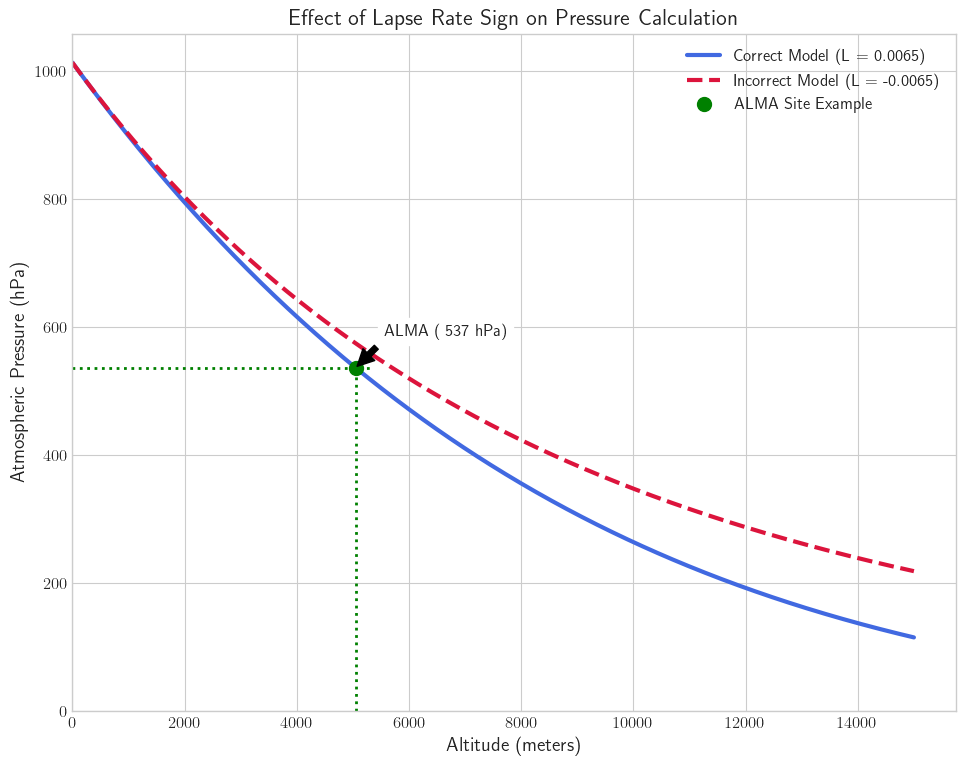

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_pressure(P0, T0, L, h, h0):
    """
    Calculates pressure using the barometric formula.
    P0: Sea-level pressure (Pa)
    T0: Sea-level temperature (K)
    L:  Temperature lapse rate (K/m)
    h:  Target altitude (m)
    h0: Reference altitude (m)
    """
    g = 9.80665
    R = 8.31446  # Universal gas constant
    M = 0.0289644 # Molar mass of dry air

    # The core of the formula
    base = (1 - L * (h - h0) / T0)
    exponent = (g * M) / (R * L)

    pressure = P0 * (base ** exponent)
    return pressure

# --- Parameters for the plot ---
P_sea_level = 101325  # Standard sea level pressure in Pascals
T_sea_level = 288.15    # Standard sea level temperature in Kelvin (15°C)
h0_sea_level = 0        # Reference altitude is sea level

# Define a range of altitudes to plot, from sea level to 15 km
altitudes = np.linspace(0, 15000, 500)

# --- Calculate pressure profiles for both cases ---

# Case 1: Physically Correct Positive Lapse Rate (L > 0)
L_positive = 0.0065
pressure_correct = calculate_pressure(P_sea_level, T_sea_level, L_positive, altitudes, h0_sea_level)

# Case 2: Physically Incorrect Negative Lapse Rate (L < 0)
L_negative = -0.0065
pressure_incorrect = calculate_pressure(P_sea_level, T_sea_level, L_negative, altitudes, h0_sea_level)

# --- Create the Plot ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the correct pressure curve
ax.plot(altitudes, pressure_correct / 100, color='royalblue', lw=3,
        label=f'Correct Model (L = {L_positive})')

# Plot the incorrect pressure curve
ax.plot(altitudes, pressure_incorrect / 100, color='crimson', lw=3, linestyle='--',
        label=f'Incorrect Model (L = {L_negative})')

# --- Add ALMA reference point for context ---
ALMA_altitude = 5050
ALMA_pressure = calculate_pressure(P_sea_level, T_sea_level, L_positive, ALMA_altitude, h0_sea_level) / 100
ax.axhline(y=ALMA_pressure, color='green', linestyle=':', lw=2, xmax=ALMA_altitude/altitudes.max())
ax.axvline(x=ALMA_altitude, color='green', linestyle=':', lw=2, ymax=ALMA_pressure/ax.get_ylim()[1])
ax.plot(ALMA_altitude, ALMA_pressure, 'o', color='green', markersize=10, label='ALMA Site Example')
ax.annotate(f'ALMA (~{ALMA_pressure:.0f} hPa)',
            xy=(ALMA_altitude, ALMA_pressure),
            xytext=(ALMA_altitude + 500, ALMA_pressure + 50),
            arrowprops=dict(facecolor='black', shrink=0.05),
            fontsize=12, backgroundcolor='white')

# --- Formatting ---
ax.set_title('Effect of Lapse Rate Sign on Pressure Calculation', fontsize=16, weight='bold')
ax.set_xlabel('Altitude (meters)', fontsize=14)
ax.set_ylabel('Atmospheric Pressure (hPa)', fontsize=14)
ax.legend(fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_ylim(bottom=0)
ax.set_xlim(left=0)

plt.tight_layout()
plt.show()

### Combined Plot

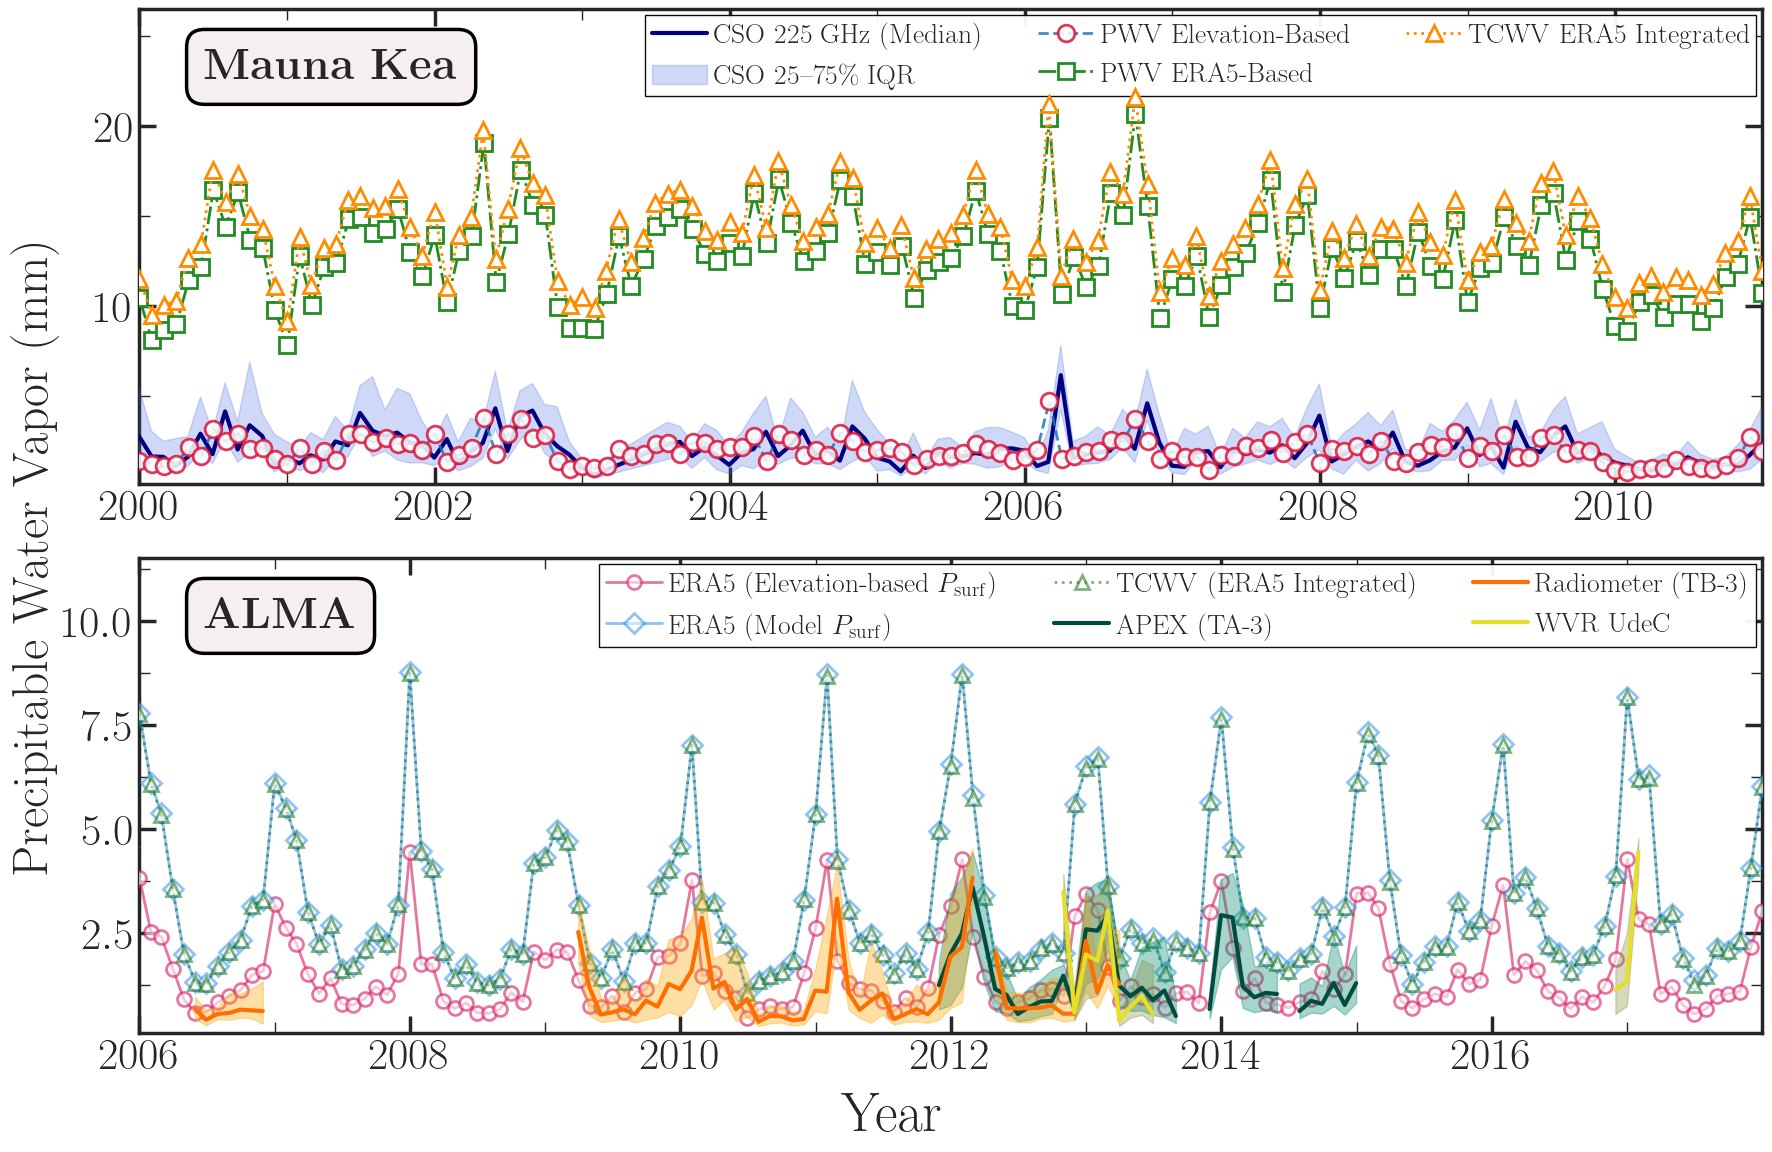

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import AutoMinorLocator
import pandas as pd
import numpy as np

# ----------------------------
# 1. Professional Plot Style with LaTeX
# ----------------------------
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": 20,
    "axes.labelsize": 32,
    "xtick.labelsize": 32,
    "ytick.labelsize": 32,
    "legend.fontsize": 22,
    "axes.linewidth": 2.8,
    "xtick.major.size": 12, "xtick.minor.size": 8,
    "ytick.major.size": 12, "ytick.minor.size": 8,
    "xtick.major.width": 2.5, "xtick.minor.width": 1.0,
    "ytick.major.width": 2.5, "ytick.minor.width": 1.0,
})

# ----------------------------
# 2. Setup Subplots: 2 Rows × 1 Column
# ----------------------------
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18, 12), sharex=False, sharey=False)
fig.subplots_adjust(hspace=0.1)

# ============================
# === Helper Function for Gap-Aware Plotting ===
# ============================
def plot_with_gaps(ax, df, color_line, color_fill, label=None):
    times = pd.to_datetime(df.index)
    median = df['median'].values
    q25 = df['q25'].values
    q75 = df['q75'].values

    time_diffs = np.diff(times.values).astype('timedelta64[D]').astype(int)
    gap_indices = np.where(time_diffs > 60)[0]  # 2 months ~ 60 days
    segments = np.split(np.arange(len(times)), gap_indices + 1)

    for i, segment in enumerate(segments):
        if len(segment) < 2:
            continue
        seg_times = times[segment]
        seg_median = median[segment]
        seg_q25 = q25[segment]
        seg_q75 = q75[segment]

        ax.plot(seg_times, seg_median, color=color_line, lw=3.0,
                label=label if i == 0 and label is not None else "", zorder=15)
        ax.fill_between(seg_times, seg_q25, seg_q75, color=color_fill, alpha=0.35, zorder=10)

# ============================
# === Top Plot: Mauna Kea ===
# ============================
ax1 = axes[0]

ax1.plot(monthly.index, monthly['median'],
         color='navy', lw=3.0, label='CSO 225 GHz (Median)', zorder=11)
ax1.fill_between(monthly.index, monthly['q25'], monthly['q75'],
                 color='royalblue', alpha=0.25, label='CSO 25--75\% IQR', zorder=9)

ax1.plot(time_values_datetime, pwv_old_values,
         label='PWV Elevation-Based', marker='o', linestyle='--',
         mfc='white', mec='crimson', mew=2.0, ms=12, lw=2.0, zorder=11,alpha=0.85,)

ax1.plot(time_values_datetime, pwv_new_values,
         label='PWV ERA5-Based', marker='s', linestyle='-.',
         mfc='white', mec='forestgreen', mew=2.0, ms=12, lw=2.0, zorder=12,
         color='forestgreen')  # Ensure line color matches marker edge color

ax1.plot(mauna_kea_tcwv.valid_time, mauna_kea_tcwv,
         label='TCWV ERA5 Integrated', marker='^', linestyle=':',
         mfc='white', mec='darkorange', mew=2.0, ms=12, lw=2.0, zorder=13,
         color='darkorange')  # Ensure line color matches marker edge color

ax1.set_xlim(pd.Timestamp("2000-01-01"), pd.Timestamp("2010-12-31"))
ax1.xaxis.set_major_locator(mdates.YearLocator(base=2))
ax1.xaxis.set_minor_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.tick_params(axis='both', which='both', direction='in', top=True, right=True)
ax1.yaxis.set_minor_locator(AutoMinorLocator(2))
ax1.legend(loc='upper right', frameon=True, edgecolor='black',
          fancybox=False, shadow=False, borderpad=0.25, borderaxespad=0.2, handletextpad=0.25, fontsize=20, framealpha=0.95, ncol=3)
ax1.grid(False)
ax1.set_ylim(0.1, 26.5)


# ============================
# === Bottom Plot: ALMA ===
# ============================
ax2 = axes[1]

# ax2.plot(pwv_alma_old.time, pwv_alma_old.values,
#          label=r'ERA5 (Elevation-based $P_{\mathrm{surf}}$)',
#          marker='o', linestyle='solid', mfc='white', mec='#D81B60',
#          mew=2.0, ms=10, lw=2.0, alpha=0.6, zorder=5)

# ax2.plot(pwv_alma_new.time, pwv_alma_new.values,
#          label=r'ERA5 (Model $P_{\mathrm{surf}}$)',
#          marker='D', linestyle='solid', mfc='white', mec='#1E88E5',
#          mew=2.0, ms=10, lw=2.0, alpha=0.6, zorder=6)
ax2.plot(pwv_alma_old.time, pwv_alma_old.values,
         label=r'ERA5 (Elevation-based $P_{\mathrm{surf}}$)',
         marker='o', linestyle='solid', mfc='white', mec='#D81B60',
         mew=2.0, ms=10, lw=2.0, alpha=0.6, zorder=5,
         color='#D81B60')  # line color matches marker edge color

ax2.plot(pwv_alma_new.time, pwv_alma_new.values,
         label=r'ERA5 (Model $P_{\mathrm{surf}}$)',
         marker='D', linestyle='solid', mfc='white', mec='#1E88E5',
         mew=2.0, ms=10, lw=2.0, alpha=0.5, zorder=6,
         color='#1E88E5')  # line color matches marker edge color
ax2.plot(tcwv_alma.valid_time, tcwv_alma,
         label='TCWV (ERA5 Integrated)',
         marker='^', linestyle=':',
         mfc='white', mec='darkgreen', mew=2.0, ms=10, lw=2.0, alpha=0.5, zorder=6,
         color='darkgreen')

obs_palette = {
    "APEX (TA-3)": ('#004D40', '#00876c'),
    "Radiometer (TB-3)": ('#FF6F00', '#ffa600'),
    "WVR UdeC": ("#E5DF26", "#8b9343")
}

# Ensure datetime formatting
for label, df in observational_stats_alma.items():
    if df is not None:
        df.index = pd.to_datetime(df.index)
        df['median'] = pd.to_numeric(df['median'], errors='coerce')
        df['q25'] = pd.to_numeric(df['q25'], errors='coerce')
        df['q75'] = pd.to_numeric(df['q75'], errors='coerce')

for label, df_stats in observational_stats_alma.items():
    if df_stats is not None and not df_stats.empty:
        color_line, color_band = obs_palette[label]

        # Sort to ensure temporal order
        df_stats = df_stats.sort_index()

        # Identify gaps larger than 60 days
        time_deltas = df_stats.index.to_series().diff().dt.days
        gap_mask = time_deltas > 60
        segment_indices = gap_mask[gap_mask].index

        # Initialize segment start
        start_idx = 0
        segments = []

        for gap_time in segment_indices:
            end_idx = df_stats.index.get_loc(gap_time)
            segments.append(df_stats.iloc[start_idx:end_idx])
            start_idx = end_idx
        segments.append(df_stats.iloc[start_idx:])  # Final segment

        # Flag to track if we've added the label
        label_added = False

        for segment in segments:
            if len(segment) < 2:
                continue

            ax2.plot(segment.index, segment['median'],
                     color=color_line,
                     linestyle='-', linewidth=3.0,
                     label=label if not label_added else None,
                     zorder=15)

            ax2.fill_between(segment.index, segment['q25'], segment['q75'],
                             color=color_band,
                             alpha=0.35,
                             zorder=10)

            label_added = True  # Avoid duplicate legend entry

ax2.set_xlim(pd.Timestamp("2006-01-01"), pd.Timestamp("2017-12-31"))
ax2.set_ylim(0.1, 11.5)

ax2.xaxis.set_major_locator(mdates.YearLocator(base=2))
ax2.xaxis.set_minor_locator(mdates.YearLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax2.tick_params(axis='both', which='both', direction='in', top=True, right=True)
ax2.yaxis.set_minor_locator(AutoMinorLocator(2))
ax2.legend(loc='upper right', frameon=True, edgecolor='black',
          fancybox=False, shadow=False, borderpad=0.25, borderaxespad=0.2, handletextpad=0.25, fontsize=20, framealpha=0.95, ncol=3)

ax2.grid(False)


axes[0].text(0.04, 0.92, r'\textbf{Mauna Kea}', transform=axes[0].transAxes,
             fontsize=32, verticalalignment='top',
             bbox=dict(boxstyle='round,pad=0.4', facecolor="#f5efef", edgecolor='black', linewidth=2.5))

axes[1].text(0.04, 0.92, r'\textbf{ALMA}', transform=axes[1].transAxes,
             fontsize=32, verticalalignment='top',
             bbox=dict(boxstyle='round,pad=0.4', facecolor='#f5efef', edgecolor='black', linewidth=2.5))

ax1.spines['top'].set_linewidth(2.5)
ax1.spines['right'].set_linewidth(2.5)
ax1.spines['bottom'].set_linewidth(2.5)
ax1.spines['left'].set_linewidth(2.5)

ax2.spines['top'].set_linewidth(2.5)
ax2.spines['right'].set_linewidth(2.5)
ax2.spines['bottom'].set_linewidth(2.5)
ax2.spines['left'].set_linewidth(2.5)

# ----------------------------
# 3. Common Labels and Save
# ----------------------------
fig.text(0.5, 0.02, r'Year', ha='center', fontsize=40)
fig.text(0.01, 0.5, r'Precipitable Water Vapor (mm)', va='center', rotation='vertical', fontsize=36)

plt.tight_layout(rect=[0.04, 0.04, 1, 0.98])
plt.savefig("Combined_PWV_MaunaKea_ALMA.pdf",
            dpi=400, format='pdf', bbox_inches='tight')
plt.show()


NameError: name 'monthly' is not defined

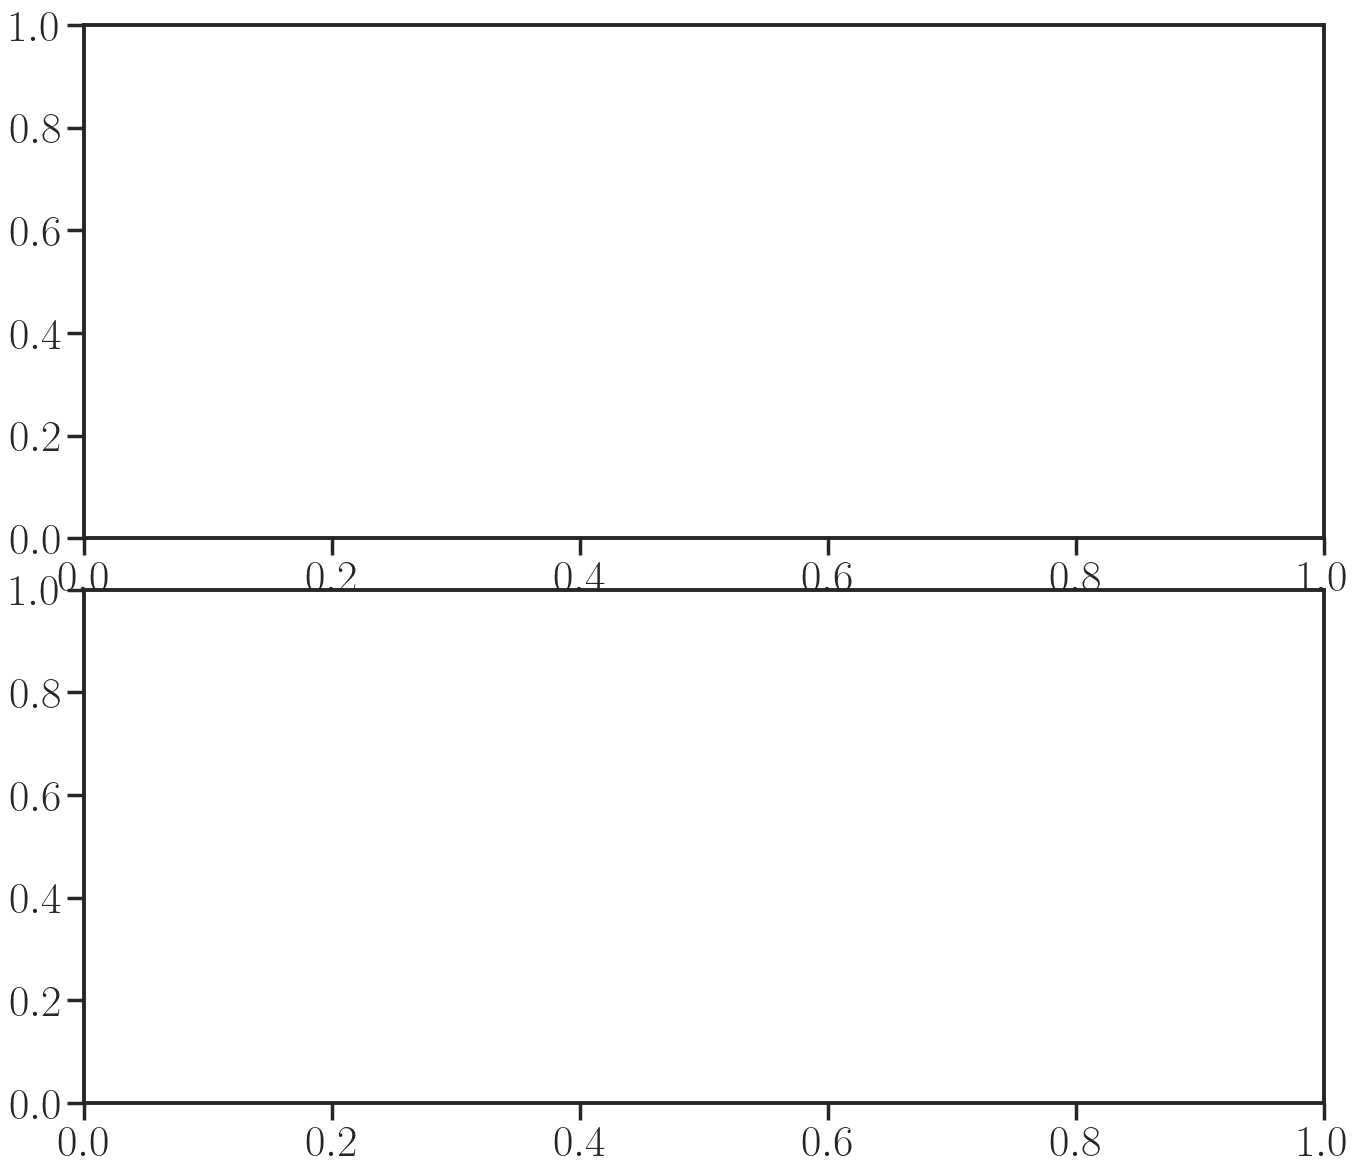

In [60]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import AutoMinorLocator
import pandas as pd
import numpy as np

# ----------------------------
# 1. Professional Plot Style with LaTeX
# ----------------------------
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": 20,
    "axes.labelsize": 32,
    "xtick.labelsize": 32,
    "ytick.labelsize": 32,
    "legend.fontsize": 22,
    "axes.linewidth": 2.8,
    "xtick.major.size": 12, "xtick.minor.size": 8,
    "ytick.major.size": 12, "ytick.minor.size": 8,
    "xtick.major.width": 2.5, "xtick.minor.width": 1.0,
    "ytick.major.width": 2.5, "ytick.minor.width": 1.0,
})

# ----------------------------
# 2. Setup Subplots: 2 Rows × 1 Column
# ----------------------------
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 14), sharex=False, sharey=False)
fig.subplots_adjust(hspace=0.1)

# ============================
# === Helper Function for Gap-Aware Plotting ===
# ============================
def plot_with_gaps(ax, df, color_line, color_fill, label=None):
    times = pd.to_datetime(df.index)
    median = df['median'].values
    q25 = df['q25'].values
    q75 = df['q75'].values

    time_diffs = np.diff(times.values).astype('timedelta64[D]').astype(int)
    gap_indices = np.where(time_diffs > 60)[0]  # 2 months ~ 60 days
    segments = np.split(np.arange(len(times)), gap_indices + 1)

    for i, segment in enumerate(segments):
        if len(segment) < 2:
            continue
        seg_times = times[segment]
        seg_median = median[segment]
        seg_q25 = q25[segment]
        seg_q75 = q75[segment]

        ax.plot(seg_times, seg_median, color=color_line, lw=3.0,
                label=label if i == 0 and label is not None else "", zorder=15)
        ax.fill_between(seg_times, seg_q25, seg_q75, color=color_fill, alpha=0.35, zorder=10)

# ============================
# === Top Plot: Mauna Kea ===
# ============================
ax1 = axes[0]

ax1.plot(monthly.index, monthly['median'],
         color='navy', lw=3.0, label='CSO 225 GHz (Median)', zorder=11)
ax1.fill_between(monthly.index, monthly['q25'], monthly['q75'],
                 color='royalblue', alpha=0.25, label='CSO 25--75\% IQR', zorder=9)

ax1.plot(time_values_datetime, pwv_old_values,
         label='PWV Elevation-Based', marker='o', linestyle='--',
         mfc='white', mec='crimson', mew=2.0, ms=12, lw=2.0, zorder=11,alpha=0.85,)

ax1.plot(time_values_datetime, pwv_new_values,
         label='PWV ERA5-Based', marker='s', linestyle='-.',
         mfc='white', mec='forestgreen', mew=2.0, ms=12, lw=2.0, zorder=12,
         color='forestgreen')  # Ensure line color matches marker edge color

ax1.plot(mauna_kea_tcwv.valid_time, mauna_kea_tcwv,
         label='TCWV ERA5 Integrated', marker='^', linestyle=':',
         mfc='white', mec='darkorange', mew=2.0, ms=12, lw=2.0, zorder=13,
         color='darkorange')  # Ensure line color matches marker edge color

ax1.set_xlim(pd.Timestamp("2000-01-01"), pd.Timestamp("2010-12-31"))
ax1.xaxis.set_major_locator(mdates.YearLocator(base=2))
ax1.xaxis.set_minor_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.tick_params(axis='both', which='both', direction='in', top=True, right=True)
ax1.yaxis.set_minor_locator(AutoMinorLocator(2))
ax1.legend(loc='upper right', frameon=True, edgecolor='black',
          fancybox=False, shadow=False, borderpad=0.25, borderaxespad=0.2, handletextpad=0.25, fontsize=20, framealpha=0.95, ncol=3)
ax1.grid(False)
ax1.set_ylim(0.1, 26.5)


# ============================
# === Bottom Plot: ALMA ===
# ============================
ax2 = axes[1]

# ax2.plot(pwv_alma_old.time, pwv_alma_old.values,
#          label=r'ERA5 (Elevation-based $P_{\mathrm{surf}}$)',
#          marker='o', linestyle='solid', mfc='white', mec='#D81B60',
#          mew=2.0, ms=10, lw=2.0, alpha=0.6, zorder=5)

# ax2.plot(pwv_alma_new.time, pwv_alma_new.values,
#          label=r'ERA5 (Model $P_{\mathrm{surf}}$)',
#          marker='D', linestyle='solid', mfc='white', mec='#1E88E5',
#          mew=2.0, ms=10, lw=2.0, alpha=0.6, zorder=6)
ax2.plot(pwv_alma_old.time, pwv_alma_old.values,
         label=r'ERA5 (Elevation-based $P_{\mathrm{surf}}$)',
         marker='o', linestyle='solid', mfc='white', mec='#D81B60',
         mew=2.0, ms=10, lw=2.0, alpha=0.6, zorder=5,
         color='#D81B60')  # line color matches marker edge color

ax2.plot(pwv_alma_new.time, pwv_alma_new.values,
         label=r'ERA5 (Model $P_{\mathrm{surf}}$)',
         marker='D', linestyle='solid', mfc='white', mec='#1E88E5',
         mew=2.0, ms=10, lw=2.0, alpha=0.5, zorder=6,
         color='#1E88E5')  # line color matches marker edge color
ax2.plot(tcwv_alma.valid_time, tcwv_alma,
         label='TCWV (ERA5 Integrated)',
         marker='^', linestyle=':',
         mfc='white', mec='darkgreen', mew=2.0, ms=10, lw=2.0, alpha=0.5, zorder=6,
         color='darkgreen')

obs_palette = {
    "APEX (TA-3)": ('#004D40', '#00876c'),
    "Radiometer (TB-3)": ('#FF6F00', '#ffa600'),
    "WVR UdeC": ("#E5DF26", "#8b9343")
}

# Ensure datetime formatting
for label, df in observational_stats_alma.items():
    if df is not None:
        df.index = pd.to_datetime(df.index)
        df['median'] = pd.to_numeric(df['median'], errors='coerce')
        df['q25'] = pd.to_numeric(df['q25'], errors='coerce')
        df['q75'] = pd.to_numeric(df['q75'], errors='coerce')

for label, df_stats in observational_stats_alma.items():
    if df_stats is not None and not df_stats.empty:
        color_line, color_band = obs_palette[label]

        # Sort to ensure temporal order
        df_stats = df_stats.sort_index()

        # Identify gaps larger than 60 days
        time_deltas = df_stats.index.to_series().diff().dt.days
        gap_mask = time_deltas > 60
        segment_indices = gap_mask[gap_mask].index

        # Initialize segment start
        start_idx = 0
        segments = []

        for gap_time in segment_indices:
            end_idx = df_stats.index.get_loc(gap_time)
            segments.append(df_stats.iloc[start_idx:end_idx])
            start_idx = end_idx
        segments.append(df_stats.iloc[start_idx:])  # Final segment

        # Flag to track if we've added the label
        label_added = False

        for segment in segments:
            if len(segment) < 2:
                continue

            ax2.plot(segment.index, segment['median'],
                     color=color_line,
                     linestyle='-', linewidth=3.0,
                     label=label if not label_added else None,
                     zorder=15)

            ax2.fill_between(segment.index, segment['q25'], segment['q75'],
                             color=color_band,
                             alpha=0.35,
                             zorder=10)

            label_added = True  # Avoid duplicate legend entry

ax2.set_xlim(pd.Timestamp("2006-01-01"), pd.Timestamp("2017-12-31"))
ax2.set_ylim(0.1, 11.5)

ax2.xaxis.set_major_locator(mdates.YearLocator(base=2))
ax2.xaxis.set_minor_locator(mdates.YearLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax2.tick_params(axis='both', which='both', direction='in', top=True, right=True)
ax2.yaxis.set_minor_locator(AutoMinorLocator(2))
ax2.legend(loc='upper right', frameon=True, edgecolor='black',
          fancybox=False, shadow=False, borderpad=0.25, borderaxespad=0.2, handletextpad=0.25, fontsize=20, framealpha=0.95, ncol=3)

ax2.grid(False)


axes[0].text(0.04, 0.92,
             r'\parbox[c]{2cm}{\centering \textbf{Mauna}\\\textbf{Kea}}',
             transform=axes[0].transAxes,
             fontsize=32, ha='left', va='top',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='#f5efef', edgecolor='black', linewidth=2.5))

axes[1].text(0.04, 0.92, r'\textbf{ALMA}', transform=axes[1].transAxes,
             fontsize=32, verticalalignment='top',
             bbox=dict(boxstyle='round,pad=0.4', facecolor='#f5efef', edgecolor='black', linewidth=2.5))

ax1.spines['top'].set_linewidth(2.5)
ax1.spines['right'].set_linewidth(2.5)
ax1.spines['bottom'].set_linewidth(2.5)
ax1.spines['left'].set_linewidth(2.5)

ax2.spines['top'].set_linewidth(2.5)
ax2.spines['right'].set_linewidth(2.5)
ax2.spines['bottom'].set_linewidth(2.5)
ax2.spines['left'].set_linewidth(2.5)

# ----------------------------
# 3. Common Labels and Save
# ----------------------------
fig.text(0.5, 0.02, r'Year', ha='center', fontsize=40)
fig.text(0.01, 0.5, r'Precipitable Water Vapor (mm)', va='center', rotation='vertical', fontsize=36)

plt.tight_layout(rect=[0.04, 0.04, 1, 0.98])
plt.savefig("Combined_PWV_MaunaKea_ALMA.png",
            dpi=400, bbox_inches='tight')
plt.show()
